In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

from IPython.display import display, Markdown
from IPython.display import display
from datetime import timedelta

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid", palette="colorblind")
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2.5,
})

# Configuration
FORECAST_HORIZONS = [1, 7, 14, 30]
TEST_SIZE_DAYS = 30  # Last 30 days for testing
RANDOM_STATE = 42
MODEL_DIR = '../models/xgboost_baseline'


# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

print("✓ Imports complete")

✓ Imports complete


<br> <br> <br>

### 1. Creating and Imporing Datasets

In [2]:
# Edges
df_edges_plant = pd.read_csv("../data/SupplyGraph/Edges/Edges (Plant).csv")
df_edges_product_group = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Group).csv")
df_edges_product_subgroup = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Sub-Group).csv")
df_edges_storage_location = pd.read_csv("../data/SupplyGraph/Edges/Edges (Storage Location).csv")

# Nodes
df_nodes_productgroup_and_subgroup = pd.read_csv("../data/SupplyGraph/Nodes/Node Types (Product Group and Subgroup).csv")
df_nodes_plant_and_storage = pd.read_csv("../data/SupplyGraph/Nodes/Nodes Type (Plant & Storage).csv")
df_nodes = pd.read_csv("../data/SupplyGraph/Nodes/Nodes.csv")
# df_nodes_index = pd.read_csv("../data/SupplyGraph/Nodes/NodesIndex.csv")

# Temporal
df_temporal_delivery_to_distributor = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Delivery To distributor.csv")
df_temporal_factory_issue = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Factory Issue.csv")
df_temporal_production = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Production.csv")
df_temporal_sales_order = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Sales Order.csv")


# Pivot the datasets
df_temporal_sales_order['Date'] = pd.to_datetime(df_temporal_sales_order['Date'])
df_temporal_sales_order_pivot = df_temporal_sales_order.melt(id_vars='Date', var_name='Product', value_name='Sales').dropna()
df_temporal_production['Date'] = pd.to_datetime(df_temporal_production['Date'])
df_temporal_production_pivot = df_temporal_production.melt(id_vars='Date', var_name='Product', value_name='Production Quantity').dropna()
df_temporal_factory_issue['Date'] = pd.to_datetime(df_temporal_factory_issue['Date'])
df_temporal_factory_issue_pivot = df_temporal_factory_issue.melt(id_vars='Date', var_name='Product', value_name='Factory Issue').dropna()
df_temporal_delivery_to_distributor['Date'] = pd.to_datetime(df_temporal_delivery_to_distributor['Date'])
df_temporal_delivery_to_distributor_pivot = df_temporal_delivery_to_distributor.melt(id_vars='Date', var_name='Product', value_name='Distributor').dropna()

<br> <br> <br>


#### 1.1 Create a Holiday Dataset

In [4]:
holidays_dict = [
    {
        'Date': '2023-02-21',
        'holiday_type': "National Holiday",
        'holiday_name': "Language Martyrs' Day"
    },
    {
        'Date': "2023-03-8",
        'holiday_type': "National Holiday",
        'holiday_name': "Shab e-barat"
    },   
    {
        'Date': "2023-03-17",
        'holiday_type': "National Holiday",
        'holiday_name': "Sheikh Mujibur Rahman's birthday",
    },
    {
        'Date': "2023-03-26",
        'holiday_type': "National Holiday",
        'holiday_name': "Independence Day",
    },
    {
        'Date': "2023-04-14",
        'holiday_type': "National Holiday",
        'holiday_name': "Bengali New Year" 
    },
    {
        'Date': "2023-04-19",
        'holiday_type': "National Holiday",
        'holiday_name': "Shab-e-Qadr"
    },
    {
        'Date': "2023-04-20",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid al-Fitr"
    },
    {
        'Date': "2023-04-21",
        'holiday_type': "National Holiday",
        'holiday_name': "Jumatul Bidah"
    },
    {
        'Date': "2023-04-22",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid al-Fitr"
    },
    {
        'Date': "2023-04-23",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid al-Fitr"
    },
    {
        'Date': "2023-05-01",
        'holiday_type': "National Holiday",
        'holiday_name': "Labour Day"
    },
    {
        'Date': "2023-05-04",
        'holiday_type': "National Holiday",
        'holiday_name': "Buddha Purnima"
    },
    {
        'Date': "2023-06-27",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid-ul-Azha"
    },
    {
        'Date': "2023-06-28",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid-ul-Azha"
    },
    {
        'Date': "2023-06-29",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid-ul-Azha"
    },
    {
        'Date': "2023-06-30",
        'holiday_type': "National Holiday",
        'holiday_name': "Eid-ul-Azha"
    },
    {
        'Date': "2023-07-01",
        'holiday_type': "Not a National Holiday",
        'holiday_name': "Bank Holiday"
    },
    {
        'Date': "2023-07-29",
        'holiday_type': "National Holiday",
        'holiday_name': "Ashura"
    },
    {
        'Date': "2023-08-15",
        'holiday_type': "National Holiday",
        'holiday_name': "National Mourning Day"
    },       
]


# Create dataframe from holidays_dict
df_holidays = pd.DataFrame(holidays_dict)
df_holidays['Date'] = pd.to_datetime(df_holidays['Date']).dt.normalize()

# Optional: rename for clarity
df_holidays = df_holidays.rename(columns={
    'holiday_name': 'holiday_name',
    'holiday_type': 'holiday_type'
})

# Display the newly created holidays dataframe
display(df_holidays)



,Date,holiday_type,holiday_name
0,2023-02-21,National Holiday,Language Martyrs' Day
1,2023-03-08,National Holiday,Shab e-barat
2,2023-03-17,National Holiday,Sheikh Mujibur Rahman's birthday
3,2023-03-26,National Holiday,Independence Day
4,2023-04-14,National Holiday,Bengali New Year
5,2023-04-19,National Holiday,Shab-e-Qadr
6,2023-04-20,National Holiday,Eid al-Fitr
7,2023-04-21,National Holiday,Jumatul Bidah
8,2023-04-22,National Holiday,Eid al-Fitr
9,2023-04-23,National Holiday,Eid al-Fitr


<br> <br> <br>

#### 1.2 Create a Weather Dataset

In [5]:
def load_weather_data(data_dir='../data/Weather Datasets/Station Wise Data', begin_date='2023-01-01', end_date='2023-08-09'):
    
    import glob
    
    # Convert date strings to datetime
    begin_date = pd.to_datetime(begin_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()
    
    # Get all CSV files in the directory
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    
    if len(csv_files) == 0:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    print(f"Found {len(csv_files)} CSV files")
    print(f"Date range: {begin_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
    all_dfs = []
    
    for file_path in csv_files:
        # Extract city name from filename (remove path and .csv extension)
        city_name = os.path.basename(file_path).replace('.csv', '')
        
        # Read the CSV
        df = pd.read_csv(file_path)
        
        # Add City column
        df['City'] = city_name
        
        # Check if year, month, day columns exist
        year_col = None
        month_col = None
        day_col = None
        
        for col in df.columns:
            col_lower = col.lower()
            if 'year' in col_lower:
                year_col = col
            elif 'month' in col_lower:
                month_col = col
            elif 'day' in col_lower:
                day_col = col
        
        # Create Date column from year, month, day
        if year_col and month_col and day_col:
            df['Date'] = pd.to_datetime(
                df[[year_col, month_col, day_col]].astype(int).rename(
                    columns={year_col: 'year', month_col: 'month', day_col: 'day'}
                )
            ).dt.normalize()
            
            # Drop original year, month, day columns
            df = df.drop(columns=[year_col, month_col, day_col])
            
            # Filter by date range
            df = df[(df['Date'] >= begin_date) & (df['Date'] <= end_date)]
        else:
            # Try to find existing date column
            date_col = None
            for col in df.columns:
                if 'date' in col.lower():
                    date_col = col
                    break
            
            if date_col is not None:
                df['Date'] = pd.to_datetime(df[date_col]).dt.normalize()
                if date_col != 'Date':
                    df = df.drop(columns=[date_col])
                # Filter by date range
                df = df[(df['Date'] >= begin_date) & (df['Date'] <= end_date)]
            else:
                print(f"Warning: No date columns found in {city_name}.csv")
        
        all_dfs.append(df)
        # print(f"  ✓ Loaded {city_name}: {len(df)} rows")
    
    # Concatenate all dataframes
    df_weather = pd.concat(all_dfs, ignore_index=True)
    
    # Reorder columns to put Date and City first
    cols = df_weather.columns.tolist()
    priority_cols = ['Date', 'City']
    other_cols = [c for c in cols if c not in priority_cols]
    df_weather = df_weather[priority_cols + other_cols]
    
    # print(f"\n✓ Combined weather data: {len(df_weather)} total rows")
    # print(f"  Cities: {df_weather['City'].nunique()}")
    # print(f"  Date range in data: {df_weather['Date'].min().strftime('%Y-%m-%d')} to {df_weather['Date'].max().strftime('%Y-%m-%d')}")
    # print(f"  Columns: {list(df_weather.columns)}")
    
    return df_weather


# Load weather data for 2023 with specific date range
df_weather = load_weather_data(
    data_dir='../data/Weather Datasets/Station Wise Data', 
    begin_date='2023-01-01', 
    end_date='2023-08-09'
)

df_weather.drop(columns="Unnamed: 0", inplace=True)

df_weather

Found 35 CSV files
Date range: 2023-01-01 to 2023-08-09


,Date,City,Station,Rainfall,Sunshine,Humidity,Temperature
0,2023-01-01,Ambaganctg,Ambaganctg,0.0,8.3,65.0,20.4
1,2023-01-02,Ambaganctg,Ambaganctg,0.0,8.9,73.0,19.9
2,2023-01-03,Ambaganctg,Ambaganctg,0.0,7.6,80.0,19.9
3,2023-01-04,Ambaganctg,Ambaganctg,0.0,9.4,75.0,20.4
4,2023-01-05,Ambaganctg,Ambaganctg,0.0,8.0,78.0,19.6
...,...,...,...,...,...,...,...
7730,2023-08-05,Teknaf,Teknaf,0.0,10.7,84.0,28.8
7731,2023-08-06,Teknaf,Teknaf,2.0,7.2,80.0,29.0
7732,2023-08-07,Teknaf,Teknaf,0.0,7.7,83.0,28.7
7733,2023-08-08,Teknaf,Teknaf,36.0,0.0,92.0,27.5


In [6]:
# Filter weather data for Ambaganctg (case-insensitive)
city_name = "Dhaka" # 'Ambaganctg', "Dhaka"
df_weather[df_weather['City'].astype(str).str.strip().str.lower() == city_name.lower()]

,Date,City,Station,Rainfall,Sunshine,Humidity,Temperature
1989,2023-01-01,Dhaka,Dhaka,0.0,4.0,81.0,17.9
1990,2023-01-02,Dhaka,Dhaka,0.0,5.5,71.0,19.1
1991,2023-01-03,Dhaka,Dhaka,0.0,0.0,87.0,16.2
1992,2023-01-04,Dhaka,Dhaka,0.0,0.0,91.0,14.8
1993,2023-01-05,Dhaka,Dhaka,0.0,1.3,86.0,15.2
...,...,...,...,...,...,...,...
2205,2023-08-05,Dhaka,Dhaka,55.0,5.7,81.0,29.4
2206,2023-08-06,Dhaka,Dhaka,5.0,5.0,91.0,27.8
2207,2023-08-07,Dhaka,Dhaka,18.0,4.2,95.0,27.4
2208,2023-08-08,Dhaka,Dhaka,54.0,7.1,91.0,27.3


<br> <br> <br>

#### 1.3 Create an Event Dataset

In [7]:
df_events = pd.read_csv("../data/BangladeshEvents/event.csv",  parse_dates=["date"])
df_events

,date,category,name,type,scope_or_location,typical_max_temp_C,typical_min_temp_C,typical_rain_mm,weather_basis,impact_on_supply_chain,notes,source_links
0,2023-01-01,school_university,Start of primary & secondary school academic y...,Academic session start,Nationwide,25.4,12.7,7.7,Dhaka Jan climate normals,"School-related demand (uniforms, books, transp...",Academic year in Bangladesh generally runs Jan...,https://dpe.gov.bd/|https://www.unesco.org/en/...
1,2023-01-13,cultural_event,Bishwa Ijtema 2023 – Phase 1 (13–15 Jan),Mass religious congregation (Tablighi Jamaat),Tongi near Dhaka,25.4,12.7,7.7,Dhaka Jan climate normals,Huge temporary population inflow; heavy pressu...,Event spans 3 days; treat as event window in m...,https://www.thedailystar.net/tags/biswa-ijtema
2,2023-01-20,cultural_event,Bishwa Ijtema 2023 – Phase 2 (20–22 Jan),Mass religious congregation,Tongi near Dhaka,25.4,12.7,7.7,Dhaka Jan climate normals,Similar logistical pattern to Phase 1: congest...,Use as second event window close to Dhaka mark...,https://www.thedailystar.net/tags/biswa-ijtema
3,2023-02-14,cultural_event,Pohela Falgun & Valentine's Day,Cultural festival,Urban centres (esp. Dhaka),28.1,15.5,28.9,Dhaka Feb climate normals,"High footfall in parks, campuses, restaurants;...",Good candidate for positive demand shock in ur...,https://www.thedailystar.net/news/bangladesh/n...
4,2023-02-21,national_holiday,Language Martyrs' Day / International Mother L...,Government/National holiday,Nationwide,28.1,15.5,28.9,Dhaka Feb climate normals,Processions and official ceremonies; governmen...,Can model as national_holiday dummy; demand ef...,https://www.officeholidays.com/countries/bangl...
5,2023-03-08,religious_holiday,Shab-e-Barat,Government holiday,Nationwide,32.5,20.4,65.8,Dhaka Mar climate normals,Night prayers and visits to cemeteries; some b...,Mainly timing effect on working hours and urba...,https://calendarific.com/holiday/bangladesh/sh...
6,2023-03-17,national_holiday,Sheikh Mujibur Rahman's Birthday & National Ch...,Government/National holiday,Nationwide,32.5,20.4,65.8,Dhaka Mar climate normals,Government offices closed; ceremonies and gath...,Include as national_holiday dummy.,https://www.officeholidays.com/countries/bangl...
7,2023-03-23,religious_period,Start of Ramadan 1444 (approx.),Religious fasting month,Nationwide,32.5,20.4,65.8,Dhaka Mar climate normals,"Shift of consumption to evening/night (iftar, ...",Model as month-long behavioural regime change ...,https://www.islamic-relief.org.uk/resources/is...
8,2023-03-26,national_holiday,Independence and National Day,Government/National holiday,Nationwide,32.5,20.4,65.8,Dhaka Mar climate normals,Large rallies and parades; government offices ...,Important national_holiday dummy with possible...,https://www.officeholidays.com/countries/bangl...
9,2023-04-14,cultural_holiday,Bengali New Year (Pohela Boishakh),Government holiday / Cultural new year,Nationwide (strongest in cities),33.7,23.6,156.0,Dhaka Apr climate normals,One of the biggest cultural festivals; very hi...,Strong positive demand shock in retail; possib...,https://www.timeanddate.com/holidays/banglades...


<br> <br> <br>

#### 1.4 Create a Currency Exchange Dataset

In [8]:
df_currency_exchange = pd.read_csv("../data/CurrencyExchange/Bangladeshi_Taka_to_USD.csv",  parse_dates=["Date"])
df_currency_exchange

,Date,BDT_USD
0,2023-01-02 23:58:00,104.7776
1,2023-01-03 23:58:00,101.6990
2,2023-01-04 23:58:00,101.9814
3,2023-01-05 23:58:00,102.0143
4,2023-01-06 23:58:00,102.1778
...,...,...
315,2023-12-25 23:58:00,108.3107
316,2023-12-27 23:58:00,108.0956
317,2023-12-28 23:58:00,108.6817
318,2023-12-29 23:58:00,108.1286


<br> <br> <br>

### 2. Calculate the Coefficient of Variation (CV)

In [9]:
def calculate_product_stats(df, group_col='Product', agg_col='Sales'):
    stats = (
        df.groupby(group_col)
          .agg(
              total_units=(agg_col, 'sum'),
              days_with_activity=(agg_col, lambda x: (x > 0).sum()),
              num_days=(agg_col, 'count'),
              avg_daily=(agg_col, 'mean'),
              std_daily=(agg_col, 'std')
          )
    )
    
    stats['activity_frequency'] = stats['days_with_activity'] / stats['num_days']    
    stats['cv'] = stats['std_daily'] / stats['avg_daily']
    # stats['cv'] = stats['cv'].replace([np.inf, -np.inf], np.nan)
    
    # Reset index to make group_col a regular column
    stats = stats.reset_index()
    
    return stats



# Example usage for all temporal dataframes:

# Sales statistics
sales_stats = calculate_product_stats(df_temporal_sales_order_pivot, group_col='Product', agg_col='Sales')
display(Markdown("**Sales Statistics**"))
display(sales_stats)

**Sales Statistics**

,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv
0,AT5X5K,1.782512e+05,174,221,806.566516,938.839092,0.787330,1.163995
1,ATN01K24P,6.393748e+05,179,221,2893.098569,2701.549761,0.809955,0.933791
2,ATN02K12P,1.370076e+05,177,221,619.943831,615.530467,0.800905,0.992881
3,ATPA1K24P,3.100000e+01,1,221,0.140271,2.085286,0.004525,14.866069
4,ATPPCH5X5K,1.000000e+01,1,221,0.045249,0.672673,0.004525,14.866069
5,ATWWP001K24P,9.223728e+03,159,221,41.736327,52.292598,0.719457,1.252928
6,ATWWP002K12P,3.733000e+03,125,221,16.891401,39.055150,0.565611,2.312132
7,EEA200G24P,5.000000e+00,1,221,0.022624,0.336336,0.004525,14.866069
8,EEA500G12P,1.150000e+02,3,221,0.520362,5.250610,0.013575,10.090302
9,MAC1K25P,8.880000e+02,30,221,4.018100,14.922212,0.135747,3.713749


In [10]:
def classify_speed_segment(stats_df, volume_col='total_units', frequency_col='activity_frequency',  q_high=0.8, q_mid=0.5, freq_threshold=0.5):
    
    df = stats_df.copy()
    
    # Calculate quantiles
    q80 = df[volume_col].quantile(q_high) # e.g. 153888.006 = this value changes based on stats_df
    q50 = df[volume_col].quantile(q_mid)  # e.g. 36836.0001 = this value changes based on stats_df
    print(f"q80 = {q80}")
    print(f"q50 = {q50}")
    print(f"Volume Column is: {volume_col}")
    print(f"if ({volume_col} >= {q80}) and ({frequency_col} >= {freq_threshold}) => `Fast`\nelif {volume_col} >= {q50} => `Medium`\nelse => `Slow`")
    print("\n\n")

    # Classification function
    def classify(row):
        if row[volume_col] >= q80 and row[frequency_col] > freq_threshold: # if total_unit > 153888.006 and "activity_frequency (0.7873)" > 0.4 (0.5=default value) 
            return 'Fast'
        elif row[volume_col] >= q50:
            return 'Medium'
        else:
            return 'Slow'
    
    # Apply classification
    df['speed_segment'] = df.apply(classify, axis=1)
    
    return df



# Classify sales statistics
df_stats_classified = classify_speed_segment(
    sales_stats, 
    volume_col='total_units',
    q_high=0.75,  # Top 25% instead of 20%
    q_mid=0.5,
    freq_threshold=0.4  # Lower frequency threshold
)

df_stats_classified

q80 = 153888.006
q50 = 36836.00000000001
Volume Column is: total_units
if (total_units >= 153888.006) and (activity_frequency >= 0.4) => `Fast`
elif total_units >= 36836.00000000001 => `Medium`
else => `Slow`





,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv,speed_segment
0,AT5X5K,1.782512e+05,174,221,806.566516,938.839092,0.787330,1.163995,Fast
1,ATN01K24P,6.393748e+05,179,221,2893.098569,2701.549761,0.809955,0.933791,Fast
2,ATN02K12P,1.370076e+05,177,221,619.943831,615.530467,0.800905,0.992881,Medium
3,ATPA1K24P,3.100000e+01,1,221,0.140271,2.085286,0.004525,14.866069,Slow
4,ATPPCH5X5K,1.000000e+01,1,221,0.045249,0.672673,0.004525,14.866069,Slow
5,ATWWP001K24P,9.223728e+03,159,221,41.736327,52.292598,0.719457,1.252928,Slow
6,ATWWP002K12P,3.733000e+03,125,221,16.891401,39.055150,0.565611,2.312132,Slow
7,EEA200G24P,5.000000e+00,1,221,0.022624,0.336336,0.004525,14.866069,Slow
8,EEA500G12P,1.150000e+02,3,221,0.520362,5.250610,0.013575,10.090302,Slow
9,MAC1K25P,8.880000e+02,30,221,4.018100,14.922212,0.135747,3.713749,Slow



<br> <br> <br>

#### 2.1 – Identify Product

In [11]:
def get_products_by_speed_segment(df_classified, mover='Fast'):
    """
    Get products filtered by speed segment.
    
    Args:
        df_classified: pandas.DataFrame - classified dataframe with 'speed_segment' column
        mover: str or list - speed segment(s) to filter by
               Can be: 'Fast', 'Medium', 'Slow', 'all'
               Or a list: ['Fast', 'Medium'], ['Fast', 'Slow'], etc.
               
    Returns:
        list: List of unique product names matching the specified segment(s)
    """
    valid_segments = ['Fast', 'Medium', 'Slow']
    
    # Handle 'all' case
    if mover == 'all':
        products = df_classified['Product'].dropna().drop_duplicates().tolist()
        print(f"✓ All products: {len(products)} products")
        return products
    
    # Convert single string to list for uniform processing
    if isinstance(mover, str):
        mover = [mover]
    
    # Validate input
    invalid_segments = [m for m in mover if m not in valid_segments]
    if invalid_segments:
        raise ValueError(f"Invalid segment(s): {invalid_segments}. Valid options: {valid_segments}")
    
    # Filter by speed segment(s)
    mask = df_classified['speed_segment'].isin(mover)
    products = df_classified.loc[mask, 'Product'].dropna().drop_duplicates().tolist()
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"PRODUCTS BY SPEED SEGMENT: {mover}")
    print(f"{'='*70}")
    print(f"Total products: {len(products)}")
    
    # Show breakdown by segment
    for segment in mover:
        segment_count = df_classified[df_classified['speed_segment'] == segment]['Product'].nunique()
        print(f"  - {segment}: {segment_count} products")
    
    # Display product details
    for i, product in enumerate(products, 1):
        stats = df_classified[df_classified['Product'] == product].iloc[0]
        print(f"{i:2d}. {product:15s} | Segment: {stats['speed_segment']:6s} | Volume: {stats['total_units']:>10,.0f} | CV: {stats['cv']:.3f} | Activity: {stats['activity_frequency']:.1%}")
    
    return products


# Example usage:

# Get Fast movers only
# FAST_MOVERS = get_products_by_speed_segment(df_stats_classified, mover='Fast')

# Get Medium movers only
# MEDIUM_MOVERS = get_products_by_speed_segment(df_stats_classified, mover='Medium')

# Get Slow movers only
# SLOW_MOVERS = get_products_by_speed_segment(df_stats_classified, mover='Slow')

# Get Fast and Medium movers
# FAST_AND_MEDIUM = get_products_by_speed_segment(df_stats_classified, mover=['Fast', 'Medium'])

# Get all products
ALL_PRODUCTS = get_products_by_speed_segment(df_stats_classified, mover='all')

✓ All products: 41 products


<br> <br> <br>

### 3. Prepare Base Dataset - Merging Dataframes

In [12]:
# Filter for fast movers
MOVERS = ALL_PRODUCTS

# Filter for movers
df_sales_mover = df_temporal_sales_order[['Date'] + MOVERS].copy()
df_production_mover = df_temporal_production[['Date'] + [p for p in MOVERS if p in df_temporal_production.columns]].copy()
df_factory_issue_mover = df_temporal_factory_issue[['Date'] + [p for p in MOVERS if p in df_temporal_factory_issue.columns]].copy()
df_delivery_mover = df_temporal_delivery_to_distributor[['Date'] + [p for p in MOVERS if p in df_temporal_delivery_to_distributor.columns]].copy()


# Pivot to long format
df_sales_long = df_sales_mover.melt(id_vars='Date', var_name='Product', value_name='Sales')
df_production_long = df_production_mover.melt(id_vars='Date', var_name='Product', value_name='Production')
df_factory_issue_long = df_factory_issue_mover.melt(id_vars='Date', var_name='Product', value_name='Factory_Issue')
df_delivery_long = df_delivery_mover.melt(id_vars='Date', var_name='Product', value_name='Delivery')

# Merge all temporal data
df_base = df_sales_long.merge(df_production_long, on=['Date', 'Product'], how='left')
df_base = df_base.merge(df_factory_issue_long, on=['Date', 'Product'], how='left')
df_base = df_base.merge(df_delivery_long, on=['Date', 'Product'], how='left')

# Fill NaN with 0 (no activity)
df_base = df_base.fillna(0)

# Sort by Product and Date
df_base = df_base.sort_values(['Product', 'Date']).reset_index(drop=True)

# Add Product, Group and Sub-Group
df_meta_filtered = df_nodes_productgroup_and_subgroup.rename(columns={'Node': 'Product'})
df_base = df_base.merge(df_meta_filtered[['Product', 'Group', 'Sub-Group']], on='Product', how='left')

print(f"Base dataset shape: {df_base.shape}")
print(f"\nColumns: {list(df_base.columns)}")
print(f"\nDate range: {df_base['Date'].min()} to {df_base['Date'].max()}")
print(f"Number of products: {df_base['Product'].nunique()}")
print(f"Total records: {len(df_base):,}")

df_base = df_base.drop_duplicates().reset_index(drop=True)
df_base

Base dataset shape: (9282, 8)

Columns: ['Date', 'Product', 'Sales', 'Production', 'Factory_Issue', 'Delivery', 'Group', 'Sub-Group']

Date range: 2023-01-01 00:00:00 to 2023-08-09 00:00:00
Number of products: 41
Total records: 9,282


,Date,Product,Sales,Production,Factory_Issue,Delivery,Group,Sub-Group
0,2023-01-01,AT5X5K,2642.0,1500,970.0,707.0,A,AT
1,2023-01-02,AT5X5K,1070.0,1500,1720.0,2317.0,A,AT
2,2023-01-03,AT5X5K,2355.0,2000,2964.0,2215.6,A,AT
3,2023-01-04,AT5X5K,909.8,2000,2265.0,2439.0,A,AT
4,2023-01-05,AT5X5K,3504.0,2000,1100.0,735.8,A,AT
...,...,...,...,...,...,...,...,...
9056,2023-08-05,SOS500M24P,109.0,1203,1709.0,1477.0,S,SOS
9057,2023-08-06,SOS500M24P,2897.0,1000,1735.0,1179.0,S,SOS
9058,2023-08-07,SOS500M24P,2385.0,2000,1675.0,2506.0,S,SOS
9059,2023-08-08,SOS500M24P,0.0,1024,445.0,500.0,S,SOS


In [13]:
# Prepare dataframes for merging

# 1. Filter weather data for Dhaka only
df_weather_dhaka = df_weather[df_weather['City'].str.lower() == 'dhaka'].copy()
df_weather_dhaka = df_weather_dhaka.drop(columns=['City'])  # Remove City column since it's always Dhaka

# 2. Prepare events dataframe (rename 'date' to 'Date' for consistency)
df_events_clean = df_events.copy()
df_events_clean = df_events_clean.rename(columns={'date': 'Date'})
df_events_clean['Date'] = pd.to_datetime(df_events_clean['Date']).dt.normalize()

# 3. Prepare currency exchange dataframe
df_currency_clean = df_currency_exchange.copy()
df_currency_clean['Date'] = pd.to_datetime(df_currency_clean['Date']).dt.normalize()

# 4. Prepare holidays dataframe
df_holidays_clean = df_holidays.copy()
df_holidays_clean['Date'] = pd.to_datetime(df_holidays_clean['Date']).dt.normalize()

# 5. Ensure df_base Date is normalized
df_base['Date'] = pd.to_datetime(df_base['Date']).dt.normalize()

# Merge all dataframes
print("Merging dataframes...")

# Merge with holidays
df_merged = df_base.merge(df_holidays_clean, on='Date', how='left')
print(f"  ✓ Merged with holidays: {df_merged.shape}")

# Merge with weather (Dhaka only)
df_merged = df_merged.merge(df_weather_dhaka, on='Date', how='left')
print(f"  ✓ Merged with weather (Dhaka): {df_merged.shape}")

# Merge with events
df_merged = df_merged.merge(df_events_clean, on='Date', how='left')
print(f"  ✓ Merged with events: {df_merged.shape}")

# Merge with currency exchange
df_merged = df_merged.merge(df_currency_clean, on='Date', how='left')
print(f"  ✓ Merged with currency exchange: {df_merged.shape}")

# Fill NaN for categorical columns
if 'Holiday' in df_merged.columns:
    df_merged['Holiday'] = df_merged['Holiday'].fillna('no_holiday')
if 'category' in df_merged.columns:
    df_merged['category'] = df_merged['category'].fillna('no_event')

df_merged

df_merged.drop(columns=["name", "type", "typical_max_temp_C", "typical_min_temp_C", "weather_basis", "impact_on_supply_chain", "notes", "source_links"], inplace=True)

Merging dataframes...
  ✓ Merged with holidays: (9061, 10)
  ✓ Merged with weather (Dhaka): (9061, 15)
  ✓ Merged with events: (9061, 26)
  ✓ Merged with currency exchange: (9061, 27)


## 4. Feature Engineering Pipeline

### 4.1 Temporal Features (Lags and Rolling Windows)

In [14]:
def create_lag_features(df, target_col='Sales', lags=[1, 2, 3, 7, 14, 21, 28]):
    """
    Create lag features for each product
    """
    df_feat = df.copy()
    
    for lag in lags:
        df_feat[f'{target_col}_lag_{lag}'] = df_feat.groupby('Product')[target_col].shift(lag)
    
    return df_feat

def create_rolling_features(df, target_col='Sales', windows=[7, 14, 30]):
    """
    Create rolling window statistics
    """
    df_feat = df.copy()
    
    for window in windows:
        # Rolling mean
        df_feat[f'{target_col}_rolling_mean_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )
        
        # Rolling std
        df_feat[f'{target_col}_rolling_std_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).std())
        )
        
        # Rolling min/max
        df_feat[f'{target_col}_rolling_min_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).min())
        )
        
        df_feat[f'{target_col}_rolling_max_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).max())
        )
    
    return df_feat

# Apply lag features and rolling features for Sales
# print("Creating lag and rolling window features for Sales...")
df_features = create_lag_features(df_merged, target_col='Sales', lags=[1, 2, 3, 7, 14, 21, 28])
df_features = create_rolling_features(df_features, target_col='Sales', windows=[7, 14, 30])

# Also create features for Production, Factory_Issue, Delivery
print("Creating lag and rolling window features for Production...")
df_features = create_lag_features(df_features, target_col='Production', lags=[1, 7, 14])
df_features = create_rolling_features(df_features, target_col='Production', windows=[1, 7, 14])

print("Creating lag and rolling window features for Sales...")
df_features = create_lag_features(df_features, target_col='Factory_Issue', lags=[1, 7, 14])
df_features = create_rolling_features(df_features, target_col='Factory_Issue', windows=[1, 7, 14])

print("Creating features for Delivery...")
df_features = create_lag_features(df_features, target_col='Delivery', lags=[1, 7, 14])
df_features = create_rolling_features(df_features, target_col='Delivery', windows=[1, 7, 14])

print(f"\n✓ Temporal features created")
print(f"Total features: {df_features.shape[1]}")

Creating lag and rolling window features for Production...
Creating lag and rolling window features for Sales...
Creating features for Delivery...

✓ Temporal features created
Total features: 83


In [15]:
def create_trend_features(df, target_col='Sales'):
    """
    Create trend and momentum indicators
    """
    df_feat = df.copy()
    
    # Percent change from previous day
    df_feat[f'{target_col}_pct_change_1'] = (df_feat.groupby('Product')[target_col].pct_change(periods=1))
    
    # Percent change from 7 days ago
    df_feat[f'{target_col}_pct_change_7'] = (df_feat.groupby('Product')[target_col].pct_change(periods=7))
    
    # Difference from rolling mean (momentum)
    df_feat[f'{target_col}_momentum_7'] = (df_feat[target_col] - df_feat[f'{target_col}_rolling_mean_7'])
    
    df_feat[f'{target_col}_momentum_14'] = (df_feat[target_col] - df_feat[f'{target_col}_rolling_mean_14'])
    
    # Trend direction (comparing recent vs older period)
    df_feat[f'{target_col}_trend_7_14'] = (df_feat[f'{target_col}_rolling_mean_7'] / (df_feat[f'{target_col}_rolling_mean_14'] + 1e-6))
    
    # Replace inf with NaN
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
    
    return df_feat

print("Creating trend and momentum features...")
df_features = create_trend_features(df_features, target_col='Sales')

print(f"✓ Trend features created")
print(f"Total features: {df_features.shape[1]}")

Creating trend and momentum features...
✓ Trend features created
Total features: 88


In [16]:
def create_time_features(df):
    """
    Create cyclical time features (day, week, month)
    """
    df_feat = df.copy()
    
    # Extract time components
    df_feat['day_of_week'] = df_feat['Date'].dt.dayofweek
    df_feat['day_of_month'] = df_feat['Date'].dt.day
    df_feat['week_of_year'] = df_feat['Date'].dt.isocalendar().week
    df_feat['month'] = df_feat['Date'].dt.month
    df_feat['quarter'] = df_feat['Date'].dt.quarter       
    
    # Is weekend
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    
    # Day of year (for long-term trends)
    df_feat['day_of_year'] = df_feat['Date'].dt.dayofyear
    
    return df_feat

print("Creating cyclical time features...")
df_features = create_time_features(df_features)

print(f"✓ Time features created")
print(f"Total features: {df_features.shape[1]}")

Creating cyclical time features...
✓ Time features created
Total features: 95


In [17]:
import numpy as np

def create_cyclical_features(df):
    """
    Apply sine/cosine transformations to cyclical time features
    This helps models understand that Dec (12) is close to Jan (1), etc.
    """
    df_feat = df.copy()
    
    # Day of week (0-6, cycles weekly)
    df_feat['day_of_week_sin'] = np.sin(2 * np.pi * df_feat['day_of_week'] / 7)
    df_feat['day_of_week_cos'] = np.cos(2 * np.pi * df_feat['day_of_week'] / 7)
    
    # Day of month (1-31, cycles monthly)
    df_feat['day_of_month_sin'] = np.sin(2 * np.pi * df_feat['day_of_month'] / 31)
    df_feat['day_of_month_cos'] = np.cos(2 * np.pi * df_feat['day_of_month'] / 31)
    
    # Week of year (1-53, cycles yearly)
    df_feat['week_of_year_sin'] = np.sin(2 * np.pi * df_feat['week_of_year'] / 53)
    df_feat['week_of_year_cos'] = np.cos(2 * np.pi * df_feat['week_of_year'] / 53)
    
    # Month (1-12, cycles yearly)
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
    
    # Quarter (1-4, cycles yearly)
    df_feat['quarter_sin'] = np.sin(2 * np.pi * df_feat['quarter'] / 4)
    df_feat['quarter_cos'] = np.cos(2 * np.pi * df_feat['quarter'] / 4)
    
    # Day of year (1-366, cycles yearly)
    df_feat['day_of_year_sin'] = np.sin(2 * np.pi * df_feat['day_of_year'] / 366)
    df_feat['day_of_year_cos'] = np.cos(2 * np.pi * df_feat['day_of_year'] / 366)
    
    # Optional: Drop original cyclical features to avoid redundancy
    # df_feat = df_feat.drop(columns=['day_of_week', 'day_of_month', 'week_of_year', 
    #                                  'month', 'quarter', 'day_of_year'])
    
    return df_feat

print("Applying sine/cosine encoding to cyclical features...")
df_features = create_cyclical_features(df_features)

print(f"✓ Cyclical encoding complete")
print(f"Total features: {df_features.shape[1]}")
print(f"\nNew cyclical features added:")
cyclical_cols = [col for col in df_features.columns if '_sin' in col or '_cos' in col]
for col in cyclical_cols:
    print(f"  - {col}")

Applying sine/cosine encoding to cyclical features...
✓ Cyclical encoding complete
Total features: 107

New cyclical features added:
  - day_of_week_sin
  - day_of_week_cos
  - day_of_month_sin
  - day_of_month_cos
  - week_of_year_sin
  - week_of_year_cos
  - month_sin
  - month_cos
  - quarter_sin
  - quarter_cos
  - day_of_year_sin
  - day_of_year_cos


In [18]:
# Merge product statistics
product_stats = df_stats_classified[['Product', 'total_units', 'avg_daily', 'std_daily', 'cv', 'activity_frequency']].copy()
product_stats = product_stats.rename(columns={
                                        'total_units': 'product_total_volume',
                                        'avg_daily': 'product_avg_daily',
                                        'std_daily': 'product_std_daily',
                                        'cv': 'product_cv',
                                        'activity_frequency': 'product_activity_freq'
})

df_features = df_features.merge(product_stats, on='Product', how='left')

# One-hot encode product group
df_features = pd.get_dummies(df_features, columns=['Group'], prefix='group', drop_first=False)

print(f"✓ Product-level features added")
print(f"Total features: {df_features.shape[1]}")

✓ Product-level features added
Total features: 116


In [19]:
def create_supply_chain_features(df):
    """
    Create features capturing supply chain dynamics
    """
    df_feat = df.copy()
    
    # Production-to-sales ratio
    df_feat['production_sales_ratio'] = (df_feat['Production'] / (df_feat['Sales'] + 1e-6))
    
    # Delivery-to-sales ratio
    df_feat['delivery_sales_ratio'] = (df_feat['Delivery'] / (df_feat['Sales'] + 1e-6))
    
    # Factory issue rate (relative to production)
    df_feat['factory_issue_rate'] = (df_feat['Factory_Issue'] / (df_feat['Production'] + 1e-6))
    
    # Cumulative inventory proxy (cumsum of production - sales)
    df_feat['inventory_proxy'] = (
        df_feat.groupby('Product').apply(
            lambda x: (x['Production'] - x['Sales']).cumsum()
        ).reset_index(level=0, drop=True)
    )
    
    # Replace inf with NaN
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
    
    return df_feat

print("Creating supply chain interaction features...")
df_features = create_supply_chain_features(df_features)

print(f"✓ Supply chain features created")
print(f"Total features: {df_features.shape[1]}")

Creating supply chain interaction features...
✓ Supply chain features created
Total features: 120


In [20]:
def create_multi_horizon_targets(df, target_col='Sales', horizons=[1, 7, 14, 30]):
    """
    Create forecasting targets for multiple horizons
    For each horizon, we want to predict the sum of sales over the next N days
    """
    df_feat = df.copy()
    
    for horizon in horizons:
        # Sum of next N days
        df_feat[f'target_{horizon}d_sum'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.shift(-horizon).rolling(window=horizon, min_periods=horizon).sum())
        )
        
        # Average of next N days
        df_feat[f'target_{horizon}d_avg'] = (
            df_feat[f'target_{horizon}d_sum'] / horizon
        )
        
        # Max of next N days (peak demand)
        df_feat[f'target_{horizon}d_max'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.shift(-horizon).rolling(window=horizon, min_periods=horizon).max())
        )
    
    return df_feat


def create_shifted_targets(df, target_col='Sales', horizons=[1, 7, 14, 30]):
    """
    Create shifted target variables for multi-horizon forecasting.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe (must be sorted by Product and Date)
    target_col : str
        Name of the target column to shift (default: 'Sales')
    horizons : list
        List of horizons (in days) to create shifted targets for
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with additional columns for each horizon shift
    """
    df = df.copy()
    
    for horizon in horizons:
        # Create shifted target for each horizon
        # Shift backward (negative) to get future values
        df[f'target_{horizon}d'] = df.groupby('Product')[target_col].shift(-horizon)
    
    return df


# print("Creating multi-horizon targets...")
# # df_features = create_multi_horizon_targets(df_features, target_col='Sales', horizons=FORECAST_HORIZONS)
# df_features = create_multi_horizon_targets(df_features, target_col='Sales')



# Single horizon
# df_features = create_shifted_targets(df_features, target_col='Sales', horizons=[7])
# Multiple horizons
df_features = create_shifted_targets(df_features, target_col='Sales', horizons=[1, 7, 14, 30])

### Scaling and Encoding the data

In [23]:

def scale_and_encode_features(df, features_for_scaling=None, excluded_features=None, no_need_for_scaling_features=None, categorical_features=None, encoding_method='onehot', auto_scale_remaining=True):
    """
    Scale numerical features using MinMaxScaler and encode categorical features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    features_for_scaling : list, optional
        Features that need to be scaled using MinMaxScaler. If None and auto_scale_remaining=True,
        will automatically include all features not in excluded/no_need/categorical lists
    excluded_features : list, optional
        Features to exclude from any processing
    no_need_for_scaling_features : list, optional
        Features that don't need scaling (will be kept as is)
    categorical_features : list, optional
        Categorical features to encode
    encoding_method : str, default='onehot'
        Method for encoding: 'onehot', 'label', or 'ordinal'
    auto_scale_remaining : bool, default=True
        If True and features_for_scaling is None, automatically scale all remaining features
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with scaled and encoded features
    dict
        Dictionary containing fitted scaler and encoders for future use
    """
    from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
    
    # Initialize lists if None
    if excluded_features is None:
        excluded_features = []
    if no_need_for_scaling_features is None:
        no_need_for_scaling_features = []
    if categorical_features is None:
        categorical_features = []
    
    # Auto-determine features_for_scaling if not provided and auto_scale_remaining is True
    if features_for_scaling is None and auto_scale_remaining:
        all_features = set(df.columns)
        excluded_set = set(excluded_features + no_need_for_scaling_features + categorical_features)
        features_for_scaling = list(all_features - excluded_set)
        print(f"✓ Auto-selected {len(features_for_scaling)} features for scaling: {features_for_scaling[:5]}..." if len(features_for_scaling) > 5 else f"✓ Auto-selected {len(features_for_scaling)} features for scaling: {features_for_scaling}")
    elif features_for_scaling is None:
        features_for_scaling = []
    
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Initialize scaler and encoder info
    scaler = MinMaxScaler()
    encoders = {}
    encoded_feature_names = []
    
    # 1. Scale numerical features
    valid_scaling_features = [f for f in features_for_scaling if f in df.columns]
    if len(valid_scaling_features) > 0:
        df_processed[valid_scaling_features] = scaler.fit_transform(df[valid_scaling_features])
        print(f"✓ Scaled {len(valid_scaling_features)} features using MinMaxScaler")
    
    # 2. Encode categorical features
    valid_categorical_features = [f for f in categorical_features if f in df.columns]
    
    if len(valid_categorical_features) > 0:
        if encoding_method == 'onehot':
            # OneHot Encoding
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_data = encoder.fit_transform(df[valid_categorical_features])
            
            # Get feature names
            encoded_feature_names = encoder.get_feature_names_out(valid_categorical_features)
            
            # Create dataframe with encoded features
            encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=df.index)
            
            # Drop original categorical columns and add encoded ones
            df_processed = df_processed.drop(columns=valid_categorical_features)
            df_processed = pd.concat([df_processed, encoded_df], axis=1)
            
            encoders['onehot'] = encoder
            print(f"✓ OneHot encoded {len(valid_categorical_features)} categorical features into {len(encoded_feature_names)} columns")
            
        elif encoding_method == 'label':
            # Label Encoding (each feature separately)
            for feature in valid_categorical_features:
                encoder = LabelEncoder()
                df_processed[feature] = encoder.fit_transform(df[feature].astype(str))
                encoders[f'label_{feature}'] = encoder
            
            print(f"✓ Label encoded {len(valid_categorical_features)} categorical features")
            
        elif encoding_method == 'ordinal':
            # Ordinal Encoding
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            df_processed[valid_categorical_features] = encoder.fit_transform(df[valid_categorical_features].astype(str))
            encoders['ordinal'] = encoder
            print(f"✓ Ordinal encoded {len(valid_categorical_features)} categorical features")
    
    # Create metadata dictionary
    processing_info = {
        'scaler': scaler,
        'encoders': encoders,
        'scaled_features': valid_scaling_features,
        'categorical_features': valid_categorical_features,
        'encoded_feature_names': list(encoded_feature_names),
        'excluded_features': excluded_features,
        'no_scaling_features': no_need_for_scaling_features,
        'encoding_method': encoding_method,
        'auto_scaled': auto_scale_remaining and features_for_scaling is None
    }
    
    print(f"\nFinal shape: {df_processed.shape}")
    
    return df_processed, processing_info



In [21]:
cols = ["day_of_week", "day_of_month", "week_of_year", "month", "quarter","is_weekend", "day_of_year"]
df_features_removed = df_features.drop(columns=cols)
df_features_removed

,Date,Product,Sales,Production,Factory_Issue,Delivery,Sub-Group,holiday_type,holiday_name,Station,Rainfall,Sunshine,Humidity,Temperature,category,scope_or_location,typical_rain_mm,BDT_USD,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_7,Sales_lag_14,Sales_lag_21,Sales_lag_28,Sales_rolling_mean_7,Sales_rolling_std_7,Sales_rolling_min_7,Sales_rolling_max_7,Sales_rolling_mean_14,Sales_rolling_std_14,Sales_rolling_min_14,Sales_rolling_max_14,Sales_rolling_mean_30,Sales_rolling_std_30,Sales_rolling_min_30,Sales_rolling_max_30,Production_lag_1,Production_lag_7,Production_lag_14,Production_rolling_mean_1,Production_rolling_std_1,Production_rolling_min_1,Production_rolling_max_1,Production_rolling_mean_7,Production_rolling_std_7,Production_rolling_min_7,Production_rolling_max_7,Production_rolling_mean_14,Production_rolling_std_14,Production_rolling_min_14,Production_rolling_max_14,Factory_Issue_lag_1,Factory_Issue_lag_7,Factory_Issue_lag_14,Factory_Issue_rolling_mean_1,Factory_Issue_rolling_std_1,Factory_Issue_rolling_min_1,Factory_Issue_rolling_max_1,Factory_Issue_rolling_mean_7,Factory_Issue_rolling_std_7,Factory_Issue_rolling_min_7,Factory_Issue_rolling_max_7,Factory_Issue_rolling_mean_14,Factory_Issue_rolling_std_14,Factory_Issue_rolling_min_14,Factory_Issue_rolling_max_14,Delivery_lag_1,Delivery_lag_7,Delivery_lag_14,Delivery_rolling_mean_1,Delivery_rolling_std_1,Delivery_rolling_min_1,Delivery_rolling_max_1,Delivery_rolling_mean_7,Delivery_rolling_std_7,Delivery_rolling_min_7,Delivery_rolling_max_7,Delivery_rolling_mean_14,Delivery_rolling_std_14,Delivery_rolling_min_14,Delivery_rolling_max_14,Sales_pct_change_1,Sales_pct_change_7,Sales_momentum_7,Sales_momentum_14,Sales_trend_7_14,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,quarter_sin,quarter_cos,day_of_year_sin,day_of_year_cos,product_total_volume,product_avg_daily,product_std_daily,product_cv,product_activity_freq,group_A,group_E,group_M,group_P,group_S,production_sales_ratio,delivery_sales_ratio,factory_issue_rate,inventory_proxy,target_1d,target_7d,target_14d,target_30d
0,2023-01-01,AT5X5K,2642.0,1500,970.0,707.0,AT,NaN,NaN,Dhaka,0.0,4.0,81.0,17.9,school_university,Nationwide,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2642.000000,NaN,2642.0,2642.0,2642.000000,NaN,2642.0,2642.0,2642.000000,NaN,2642.0,2642.0,NaN,NaN,NaN,1500.0,NaN,1500.0,1500.0,1500.000000,NaN,1500.0,1500.0,1500.000000,NaN,1500.0,1500.0,NaN,NaN,NaN,970.0,NaN,970.0,970.0,970.000000,NaN,970.0,970.0,970.000000,NaN,970.0,970.0,NaN,NaN,NaN,707.0,NaN,707.0,707.0,707.000000,NaN,707.0,707.0,707.000000,NaN,707.0,707.0,NaN,NaN,0.000000,0.000000,1.000000,-0.781831,0.623490,0.201299,0.979530,-0.118273,0.992981,0.500000,0.866025,1.0,6.123234e-17,0.017166,0.999853,178251.200000,806.566516,938.839092,1.163995,0.78733,True,False,False,False,False,5.677517e-01,2.676003e-01,0.646667,-1142.000000,1070.0,3322.0,2632.0,2101.0
1,2023-01-02,AT5X5K,1070.0,1500,1720.0,2317.0,AT,NaN,NaN,Dhaka,0.0,5.5,71.0,19.1,no_event,NaN,NaN,104.7776,2642.0,NaN,NaN,NaN,NaN,NaN,NaN,1856.000000,1111.571860,1070.0,2642.0,1856.000000,1111.571860,1070.0,2642.0,1856.000000,1111.571860,1070.0,2642.0,1500.0,NaN,NaN,1500.0,NaN,1500.0,1500.0,1500.000000,0.000000,1500.0,1500.0,1500.000000,0.000000,1500.0,1500.0,970.0,NaN,NaN,1720.0,NaN,1720.0,1720.0,1345.000000,530.330086,970.0,1720.0,1345.000000,530.330086,970.0,1720.0,707.0,NaN,NaN,2317.0,NaN,2317.0,2317.0,1512.000000,1138.441918,707.0,2317.0,1512.000000,1138.441918,707.0,2317.0,-0.595004,NaN,-786.000000,-786.000000,1.000000,0.000000,1.000000,0.394356,0.918958,0.118273,0.992981,0.500000,0.866025,1.0,6.123234e-17,0.034328,0.999411,178251.200000,806.566516,938.839092,1.163995,0.78733,True,False,False,False,False,1.401869e+00,2.165421e+00,1.146667,-712.000000,2355.0,2254.0,2303.0,180.4
2,2023-01-03,AT5X5K,2355.0,2000,2964.0,2215.6,AT,NaN,NaN,Dhaka,0.0,0.0,87.0,16.2,no_event,NaN,NaN,101.6990,1070.0,2642.0,NaN,NaN,NaN,NaN,NaN,2022.333333,837.135

In [24]:
excluded_features = ["Date", "Sales", "Station", "day_of_year_sin", "day_of_year_cos" ] + ["product_total_volume", "product_avg_daily", "product_std_daily", "product_cv", "product_activity_freq"] + ["target_1d", "target_7d", "target_14d","target_30d"]

no_need_for_scaling_features = ['day_of_week_sin', 'day_of_week_cos', "day_of_month_sin", "day_of_month_cos", "week_of_year_sin", "week_of_month_cos", "month_sin", "month_cos", "quarter_sin", "quarter_cos"]

categorical_features = ['Product', 'Sub-Group', 'holiday_type', "holiday_name", "category", "scope_or_location"]


# Auto-scale all remaining features
df_processed, processing_info = scale_and_encode_features(
    df=df_features_removed,
    excluded_features=excluded_features,
    no_need_for_scaling_features=no_need_for_scaling_features,
    categorical_features=categorical_features,
    encoding_method='onehot'
)

✓ Auto-selected 88 features for scaling: ['Delivery_rolling_mean_1', 'group_E', 'Sales_lag_14', 'BDT_USD', 'Factory_Issue_lag_14']...
✓ Scaled 88 features using MinMaxScaler
✓ OneHot encoded 6 categorical features into 94 columns

Final shape: (9061, 205)


In [29]:
df_processed

,Date,Sales,Production,Factory_Issue,Delivery,Station,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_7,Sales_lag_14,Sales_lag_21,Sales_lag_28,Sales_rolling_mean_7,Sales_rolling_std_7,Sales_rolling_min_7,Sales_rolling_max_7,Sales_rolling_mean_14,Sales_rolling_std_14,Sales_rolling_min_14,Sales_rolling_max_14,Sales_rolling_mean_30,Sales_rolling_std_30,Sales_rolling_min_30,Sales_rolling_max_30,Production_lag_1,Production_lag_7,Production_lag_14,Production_rolling_mean_1,Production_rolling_std_1,Production_rolling_min_1,Production_rolling_max_1,Production_rolling_mean_7,Production_rolling_std_7,Production_rolling_min_7,Production_rolling_max_7,Production_rolling_mean_14,Production_rolling_std_14,Production_rolling_min_14,Production_rolling_max_14,Factory_Issue_lag_1,Factory_Issue_lag_7,Factory_Issue_lag_14,Factory_Issue_rolling_mean_1,Factory_Issue_rolling_std_1,Factory_Issue_rolling_min_1,Factory_Issue_rolling_max_1,Factory_Issue_rolling_mean_7,Factory_Issue_rolling_std_7,Factory_Issue_rolling_min_7,Factory_Issue_rolling_max_7,Factory_Issue_rolling_mean_14,Factory_Issue_rolling_std_14,Factory_Issue_rolling_min_14,Factory_Issue_rolling_max_14,Delivery_lag_1,Delivery_lag_7,Delivery_lag_14,Delivery_rolling_mean_1,Delivery_rolling_std_1,Delivery_rolling_min_1,Delivery_rolling_max_1,Delivery_rolling_mean_7,Delivery_rolling_std_7,Delivery_rolling_min_7,Delivery_rolling_max_7,Delivery_rolling_mean_14,Delivery_rolling_std_14,Delivery_rolling_min_14,Delivery_rolling_max_14,Sales_pct_change_1,Sales_pct_change_7,Sales_momentum_7,Sales_momentum_14,Sales_trend_7_14,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,quarter_sin,quarter_cos,day_of_year_sin,day_of_year_cos,product_total_volume,product_avg_daily,product_std_daily,product_cv,product_activity_freq,group_A,group_E,group_M,group_P,group_S,production_sales_ratio,delivery_sales_ratio,factory_issue_rate,inventory_proxy,target_1d,target_7d,target_14d,target_30d,Product_AT5X5K,Product_ATN01K24P,Product_ATN02K12P,Product_ATPA1K24P,Product_ATPPCH5X5K,Product_ATWWP001K24P,Product_ATWWP002K12P,Product_EEA200G24P,Product_EEA500G12P,Product_MAC1K25P,Product_MAHS025K,Product_MAP1K25P,Product_MAPA1K24P,Product_MAR01K24P,Product_MAR02K12P,Product_MASR025K,Product_POP001L12P,Product_POP001L12P.1,Product_POP002L09P,Product_POP005L04P,Product_POP015K,Product_POP500M24P,Product_POPF01L12P,Product_POV001L24P,Product_POV002L09P,Product_POV005L04P,Product_POV500M24P,Product_SE200G24P,Product_SE500G24P,Product_SO0001L12P,Product_SO0002L09P,Product_SO0005L04P,Product_SO0500M24P,Product_SOP001L12P,Product_SOS001L12P,Product_SOS002L09P,Product_SOS003L04P,Product_SOS005L04P,Product_SOS008L02P,Product_SOS250M48P,Product_SOS500M24P,Sub-Group_AT,Sub-Group_ATN,Sub-Group_ATPA,Sub-Group_ATPPCH,Sub-Group_ATWWP,Sub-Group_EEA,Sub-Group_MAC,Sub-Group_MAHS,Sub-Group_MAP,Sub-Group_MAPA,Sub-Group_MAR,Sub-Group_MASR,Sub-Group_POP,Sub-Group_POPF,Sub-Group_POV,Sub-Group_SE,Sub-Group_SO,Sub-Group_SOP,Sub-Group_SOS,Sub-Group_nan,holiday_type_National Holiday,holiday_type_Not a National Holiday,holiday_type_nan,holiday_name_Ashura,holiday_name_Bank Holiday,holiday_name_Bengali New Year,holiday_name_Buddha Purnima,holiday_name_Eid al-Fitr,holiday_name_Eid-ul-Azha,holiday_name_Independence Day,holiday_name_Jumatul Bidah,holiday_name_Labour Day,holiday_name_Language Martyrs' Day,holiday_name_Shab e-barat,holiday_name_Shab-e-Qadr,holiday_name_Sheikh Mujibur Rahman's birthday,holiday_name_nan,category_bank_holiday,category_cultural_event,category_cultural_holiday,category_national_holiday,category_no_event,category_religious_holiday,category_religious_period,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope

### Train - Test Split

In [ ]:
# Keep ALL data - no dropping
df_clean = df_processed.copy()

# Split based on date only
min_date = df_clean['Date'].min()  # 2023-01-01
max_date = df_clean['Date'].max()  # 2023-08-09
split_date = max_date - timedelta(days=TEST_SIZE_DAYS - 1)

# Split ALL data
train_df = df_clean[df_clean['Date'] < split_date].copy()
test_df = df_clean[df_clean['Date'] >= split_date].copy()

# For target columns: fill NaN with a special value or use masking
target_cols = [col for col in df_clean.columns if col.startswith('target_')]

# # Option 3a: Fill NaN targets with -1 (will be ignored during training)
# for col in target_cols:
#     train_df[col] = train_df[col].fillna(-1)
#     test_df[col] = test_df[col].fillna(-1)

# Option 3b: Create a mask to identify valid targets
# train_df['has_valid_target'] = ~train_df[f'target_{max(FORECAST_HORIZONS)}d_sum'].isna()

print(f"{'='*80}")
print(f"TRAIN-TEST SPLIT (ZERO Data Loss)")
print(f"{'='*80}")
print(f"\nData Range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
print(f"Split Date: {split_date.strftime('%Y-%m-%d')}")

print(f"\nTrain Set:")
print(f"  - Date range: {train_df['Date'].min().strftime('%Y-%m-%d')} to {train_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"  - Shape: {train_df.shape}")
print(f"  - ALL {len(train_df):,} rows kept")

print(f"\nTest Set:")
print(f"  - Date range: {test_df['Date'].min().strftime('%Y-%m-%d')} to {test_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"  - Shape: {test_df.shape}")
print(f"  - ALL {len(test_df):,} rows kept")

print(f"\nTotal: {len(df_clean):,} samples (100% data usage)")
print(f"Zero rows dropped!")
print(f"\n{'='*80}")

TRAIN-TEST SPLIT (ZERO Data Loss)

Data Range: 2023-01-01 to 2023-08-09
Split Date: 2023-07-11

Train Set:
  - Date range: 2023-01-01 to 2023-07-10
  - Shape: (7831, 205)
  - ALL 7,831 rows kept

Test Set:
  - Date range: 2023-07-11 to 2023-08-09
  - Shape: (1230, 205)
  - ALL 1,230 rows kept

Total: 9,061 samples (100% data usage)
Zero rows dropped!



In [31]:
train_df.shape

(7831, 205)

In [32]:
test_df.shape

(1230, 205)

<br> <br> <br>

### 8. Prepare ML-Ready Datasets

In [36]:
# Define feature columns (exclude metadata and target columns)
# exclude_cols = ['Date', 'Product', 'Sub-Group', 'has_valid_target'] + [col for col in df_clean.columns if col.startswith('target_')]
exclude_cols = ['Date', "Sales"] + [col for col in df_clean.columns if col.startswith('target_')]
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Fill remaining NaN with 0 (from lag features at the beginning)
train_df[feature_cols] = train_df[feature_cols].fillna(0)
test_df[feature_cols] = test_df[feature_cols].fillna(0)

print(f"Feature columns ({len(feature_cols)}):")
print(f"  First 10: {feature_cols[:10]}")
print(f"  Last 10: {feature_cols[-10:]}")

print(f"\nTarget columns ({len([col for col in df_clean.columns if col.startswith('target_')])}):")
print(f"  {[col for col in df_clean.columns if col.startswith('target_')]}")

# Prepare X and y using target_1d_sum
print(f"\n{'='*80}")
print(f"ML-READY DATASETS PREPARED (Using target_1d_sum)")
print(f"{'='*80}")

# Use target_1d_sum for training/testing
# target_col = 'target_1d_sum'
target_col = 'Sales'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\nTarget: {target_col}")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")


# Check for -1 values (NaN replacements)
nan_count_train = (y_train == -1).sum()
nan_count_test = (y_test == -1).sum()
print(f"\n  NaN values (marked as -1):")
print(f"    Train: {nan_count_train} ({nan_count_train/len(y_train)*100:.1f}%)")
print(f"    Test: {nan_count_test} ({nan_count_test/len(y_test)*100:.1f}%)")

print(f"\n{'='*80}")
print(f"✓ Feature engineering pipeline complete!")
print(f"  Ready to train with: X_train, y_train, X_test, y_test")
print(f"{'='*80}")

Feature columns (199):
  First 10: ['Production', 'Factory_Issue', 'Delivery', 'Station', 'Rainfall', 'Sunshine', 'Humidity', 'Temperature', 'typical_rain_mm', 'BDT_USD']
  Last 10: ['category_religious_period', 'category_school_university', 'category_weather_event', 'scope_or_location_Chattogram division & south-east', 'scope_or_location_Nationwide', 'scope_or_location_Nationwide (strongest in Buddhist communities)', 'scope_or_location_Nationwide (strongest in cities)', 'scope_or_location_Tongi near Dhaka', 'scope_or_location_Urban centres (esp. Dhaka)', 'scope_or_location_nan']

Target columns (4):
  ['target_1d', 'target_7d', 'target_14d', 'target_30d']

ML-READY DATASETS PREPARED (Using target_1d_sum)

Target: Sales
  X_train: (7831, 199), y_train: (7831,)
  X_test: (1230, 199), y_test: (1230,)

  NaN values (marked as -1):
    Train: 0 (0.0%)
    Test: 0 (0.0%)

✓ Feature engineering pipeline complete!
  Ready to train with: X_train, y_train, X_test, y_test


In [37]:
X_train

,Production,Factory_Issue,Delivery,Station,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_7,Sales_lag_14,Sales_lag_21,Sales_lag_28,Sales_rolling_mean_7,Sales_rolling_std_7,Sales_rolling_min_7,Sales_rolling_max_7,Sales_rolling_mean_14,Sales_rolling_std_14,Sales_rolling_min_14,Sales_rolling_max_14,Sales_rolling_mean_30,Sales_rolling_std_30,Sales_rolling_min_30,Sales_rolling_max_30,Production_lag_1,Production_lag_7,Production_lag_14,Production_rolling_mean_1,Production_rolling_std_1,Production_rolling_min_1,Production_rolling_max_1,Production_rolling_mean_7,Production_rolling_std_7,Production_rolling_min_7,Production_rolling_max_7,Production_rolling_mean_14,Production_rolling_std_14,Production_rolling_min_14,Production_rolling_max_14,Factory_Issue_lag_1,Factory_Issue_lag_7,Factory_Issue_lag_14,Factory_Issue_rolling_mean_1,Factory_Issue_rolling_std_1,Factory_Issue_rolling_min_1,Factory_Issue_rolling_max_1,Factory_Issue_rolling_mean_7,Factory_Issue_rolling_std_7,Factory_Issue_rolling_min_7,Factory_Issue_rolling_max_7,Factory_Issue_rolling_mean_14,Factory_Issue_rolling_std_14,Factory_Issue_rolling_min_14,Factory_Issue_rolling_max_14,Delivery_lag_1,Delivery_lag_7,Delivery_lag_14,Delivery_rolling_mean_1,Delivery_rolling_std_1,Delivery_rolling_min_1,Delivery_rolling_max_1,Delivery_rolling_mean_7,Delivery_rolling_std_7,Delivery_rolling_min_7,Delivery_rolling_max_7,Delivery_rolling_mean_14,Delivery_rolling_std_14,Delivery_rolling_min_14,Delivery_rolling_max_14,Sales_pct_change_1,Sales_pct_change_7,Sales_momentum_7,Sales_momentum_14,Sales_trend_7_14,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,quarter_sin,quarter_cos,day_of_year_sin,day_of_year_cos,product_total_volume,product_avg_daily,product_std_daily,product_cv,product_activity_freq,group_A,group_E,group_M,group_P,group_S,production_sales_ratio,delivery_sales_ratio,factory_issue_rate,inventory_proxy,Product_AT5X5K,Product_ATN01K24P,Product_ATN02K12P,Product_ATPA1K24P,Product_ATPPCH5X5K,Product_ATWWP001K24P,Product_ATWWP002K12P,Product_EEA200G24P,Product_EEA500G12P,Product_MAC1K25P,Product_MAHS025K,Product_MAP1K25P,Product_MAPA1K24P,Product_MAR01K24P,Product_MAR02K12P,Product_MASR025K,Product_POP001L12P,Product_POP001L12P.1,Product_POP002L09P,Product_POP005L04P,Product_POP015K,Product_POP500M24P,Product_POPF01L12P,Product_POV001L24P,Product_POV002L09P,Product_POV005L04P,Product_POV500M24P,Product_SE200G24P,Product_SE500G24P,Product_SO0001L12P,Product_SO0002L09P,Product_SO0005L04P,Product_SO0500M24P,Product_SOP001L12P,Product_SOS001L12P,Product_SOS002L09P,Product_SOS003L04P,Product_SOS005L04P,Product_SOS008L02P,Product_SOS250M48P,Product_SOS500M24P,Sub-Group_AT,Sub-Group_ATN,Sub-Group_ATPA,Sub-Group_ATPPCH,Sub-Group_ATWWP,Sub-Group_EEA,Sub-Group_MAC,Sub-Group_MAHS,Sub-Group_MAP,Sub-Group_MAPA,Sub-Group_MAR,Sub-Group_MASR,Sub-Group_POP,Sub-Group_POPF,Sub-Group_POV,Sub-Group_SE,Sub-Group_SO,Sub-Group_SOP,Sub-Group_SOS,Sub-Group_nan,holiday_type_National Holiday,holiday_type_Not a National Holiday,holiday_type_nan,holiday_name_Ashura,holiday_name_Bank Holiday,holiday_name_Bengali New Year,holiday_name_Buddha Purnima,holiday_name_Eid al-Fitr,holiday_name_Eid-ul-Azha,holiday_name_Independence Day,holiday_name_Jumatul Bidah,holiday_name_Labour Day,holiday_name_Language Martyrs' Day,holiday_name_Shab e-barat,holiday_name_Shab-e-Qadr,holiday_name_Sheikh Mujibur Rahman's birthday,holiday_name_nan,category_bank_holiday,category_cultural_event,category_cultural_holiday,category_national_holiday,category_no_event,category_religious_holiday,category_religious_period,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban

In [38]:
y_train

0       2642.0
1       1070.0
2       2355.0
3        909.8
4       3504.0
         ...  
9026    3326.0
9027       0.0
9028     513.0
9029    4971.0
9030    3291.0
Name: Sales, Length: 7831, dtype: float64

In [39]:
X_test

,Production,Factory_Issue,Delivery,Station,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_7,Sales_lag_14,Sales_lag_21,Sales_lag_28,Sales_rolling_mean_7,Sales_rolling_std_7,Sales_rolling_min_7,Sales_rolling_max_7,Sales_rolling_mean_14,Sales_rolling_std_14,Sales_rolling_min_14,Sales_rolling_max_14,Sales_rolling_mean_30,Sales_rolling_std_30,Sales_rolling_min_30,Sales_rolling_max_30,Production_lag_1,Production_lag_7,Production_lag_14,Production_rolling_mean_1,Production_rolling_std_1,Production_rolling_min_1,Production_rolling_max_1,Production_rolling_mean_7,Production_rolling_std_7,Production_rolling_min_7,Production_rolling_max_7,Production_rolling_mean_14,Production_rolling_std_14,Production_rolling_min_14,Production_rolling_max_14,Factory_Issue_lag_1,Factory_Issue_lag_7,Factory_Issue_lag_14,Factory_Issue_rolling_mean_1,Factory_Issue_rolling_std_1,Factory_Issue_rolling_min_1,Factory_Issue_rolling_max_1,Factory_Issue_rolling_mean_7,Factory_Issue_rolling_std_7,Factory_Issue_rolling_min_7,Factory_Issue_rolling_max_7,Factory_Issue_rolling_mean_14,Factory_Issue_rolling_std_14,Factory_Issue_rolling_min_14,Factory_Issue_rolling_max_14,Delivery_lag_1,Delivery_lag_7,Delivery_lag_14,Delivery_rolling_mean_1,Delivery_rolling_std_1,Delivery_rolling_min_1,Delivery_rolling_max_1,Delivery_rolling_mean_7,Delivery_rolling_std_7,Delivery_rolling_min_7,Delivery_rolling_max_7,Delivery_rolling_mean_14,Delivery_rolling_std_14,Delivery_rolling_min_14,Delivery_rolling_max_14,Sales_pct_change_1,Sales_pct_change_7,Sales_momentum_7,Sales_momentum_14,Sales_trend_7_14,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,quarter_sin,quarter_cos,day_of_year_sin,day_of_year_cos,product_total_volume,product_avg_daily,product_std_daily,product_cv,product_activity_freq,group_A,group_E,group_M,group_P,group_S,production_sales_ratio,delivery_sales_ratio,factory_issue_rate,inventory_proxy,Product_AT5X5K,Product_ATN01K24P,Product_ATN02K12P,Product_ATPA1K24P,Product_ATPPCH5X5K,Product_ATWWP001K24P,Product_ATWWP002K12P,Product_EEA200G24P,Product_EEA500G12P,Product_MAC1K25P,Product_MAHS025K,Product_MAP1K25P,Product_MAPA1K24P,Product_MAR01K24P,Product_MAR02K12P,Product_MASR025K,Product_POP001L12P,Product_POP001L12P.1,Product_POP002L09P,Product_POP005L04P,Product_POP015K,Product_POP500M24P,Product_POPF01L12P,Product_POV001L24P,Product_POV002L09P,Product_POV005L04P,Product_POV500M24P,Product_SE200G24P,Product_SE500G24P,Product_SO0001L12P,Product_SO0002L09P,Product_SO0005L04P,Product_SO0500M24P,Product_SOP001L12P,Product_SOS001L12P,Product_SOS002L09P,Product_SOS003L04P,Product_SOS005L04P,Product_SOS008L02P,Product_SOS250M48P,Product_SOS500M24P,Sub-Group_AT,Sub-Group_ATN,Sub-Group_ATPA,Sub-Group_ATPPCH,Sub-Group_ATWWP,Sub-Group_EEA,Sub-Group_MAC,Sub-Group_MAHS,Sub-Group_MAP,Sub-Group_MAPA,Sub-Group_MAR,Sub-Group_MASR,Sub-Group_POP,Sub-Group_POPF,Sub-Group_POV,Sub-Group_SE,Sub-Group_SO,Sub-Group_SOP,Sub-Group_SOS,Sub-Group_nan,holiday_type_National Holiday,holiday_type_Not a National Holiday,holiday_type_nan,holiday_name_Ashura,holiday_name_Bank Holiday,holiday_name_Bengali New Year,holiday_name_Buddha Purnima,holiday_name_Eid al-Fitr,holiday_name_Eid-ul-Azha,holiday_name_Independence Day,holiday_name_Jumatul Bidah,holiday_name_Labour Day,holiday_name_Language Martyrs' Day,holiday_name_Shab e-barat,holiday_name_Shab-e-Qadr,holiday_name_Sheikh Mujibur Rahman's birthday,holiday_name_nan,category_bank_holiday,category_cultural_event,category_cultural_holiday,category_national_holiday,category_no_event,category_religious_holiday,category_religious_period,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban

In [40]:
y_test

191      237.0
192      507.0
193     1044.0
194        0.0
195       29.4
         ...  
9056     109.0
9057    2897.0
9058    2385.0
9059       0.0
9060       0.0
Name: Sales, Length: 1230, dtype: float64

<br> <br> <br>

### 10. Save Processed Data

In [53]:
# Save train and test sets
train_df.drop(columns=["Station"], inplace=True)
test_df.drop(columns=["Station"], inplace=True)


train_df.to_csv('../data/processed/train_movers.csv', index=False)
test_df.to_csv('../data/processed/test_movers.csv', index=False)

print(f"{'='*80}")
print(f"DATA SAVED SUCCESSFULLY")
print(f"{'='*80}")


DATA SAVED SUCCESSFULLY


### Traning Machine Learning Models

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from datetime import datetime
import joblib
warnings.filterwarnings('ignore')

# Gradient Boosting Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Deep Learning - TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM as LSTM_TF, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam as Adam_TF

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Sklearn utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration
FORECAST_HORIZONS = [1, 7, 14, 30]
LSTM_LOOKBACK = 14
MODEL_DIR = '../models/multi_model_pytorch'
os.makedirs(MODEL_DIR, exist_ok=True)

print("✓ All imports successful")
print(f"\nVersions:")
print(f"  XGBoost:    {xgb.__version__}")
print(f"  LightGBM:   {lgb.__version__}")
print(f"  TensorFlow: {tf.__version__}")
print(f"  PyTorch:    {torch.__version__}")
print(f"\nDevice:")
print(f"  PyTorch using: {device}")
print(f"  GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
print(f"\nConfig:")
print(f"  Horizons: {FORECAST_HORIZONS}")
print(f"  LSTM Lookback: {LSTM_LOOKBACK} days")
print(f"  Random State: {RANDOM_STATE}")

✓ All imports successful

Versions:
  XGBoost:    3.1.2
  LightGBM:   4.6.0
  TensorFlow: 2.20.0
  PyTorch:    2.9.1+cpu

Device:
  PyTorch using: cpu
  GPU Available: False

Config:
  Horizons: [1, 7, 14, 30]
  LSTM Lookback: 14 days
  Random State: 42


In [ ]:
X_train = pd.read_csv()

Loading data...
✓ Data loaded

Train: (7831, 204) | Test: (1230, 204) | Features: 81


In [57]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate comprehensive evaluation metrics"""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    mask_nonzero = y_true_clean != 0
    if mask_nonzero.sum() > 0:
        mape = np.mean(np.abs((y_true_clean[mask_nonzero] - y_pred_clean[mask_nonzero]) / y_true_clean[mask_nonzero])) * 100
    else:
        mape = np.nan
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'N_samples': len(y_true_clean)
    }


def prepare_sequences_for_lstm(df, feature_cols, target_col, lookback=1):
    """Prepare sequences for LSTM training (works for both TF and PyTorch)"""
    X_sequences = []
    y_targets = []
    
    for product in df['Product'].unique():
        product_data = df[df['Product'] == product].sort_values('Date').reset_index(drop=True)
        
        # Use the passed feature_cols (which now includes encoded features)
        # Make sure these columns exist in product_data
        available_features = [col for col in feature_cols if col in product_data.columns]
        
        if len(available_features) == 0:
            print(f"Warning: No features found for product {product}")
            continue
            
        features = product_data[available_features].values
        targets = product_data[target_col].values
        
        for i in range(lookback, len(product_data)):
            # Skip if target is -1 (NaN marker)
            if targets[i] == -1 or np.isnan(targets[i]):
                continue
                
            X_sequences.append(features[i-lookback:i])
            y_targets.append(targets[i])
    
    if len(X_sequences) == 0:
        raise ValueError(f"No valid sequences created for target {target_col}. All targets may be NaN.")
    
    return np.array(X_sequences), np.array(y_targets)

# def prepare_sequences_for_lstm(df, feature_cols, target_col, lookback=30):
#     """Prepare sequences for LSTM training (works for both TF and PyTorch)"""
#     X_sequences = []
#     y_targets = []
    
#     for product in df['Product'].unique():
#         product_data = df[df['Product'] == product].sort_values('Date').reset_index(drop=True)
#         features = product_data[feature_cols].values
#         targets = product_data[target_col].values
        
#         for i in range(lookback, len(product_data)):
#             X_sequences.append(features[i-lookback:i])
#             y_targets.append(targets[i])
    
#     return np.array(X_sequences), np.array(y_targets)


def print_metrics_summary(metrics_dict):
    """Print metrics in formatted way"""
    print(f"{metrics_dict['Model']:35s} | RMSE: {metrics_dict['RMSE']:>8,.0f} | MAE: {metrics_dict['MAE']:>8,.0f} | MAPE: {metrics_dict['MAPE']:>6.2f}% | R²: {metrics_dict['R²']:>6.4f}")

print("✓ Helper functions defined")

✓ Helper functions defined


<br> <br> <br>

## 4. Model 1: XGBoost

In [68]:
X_train = pd.read_csv("../data/processed/train_movers.csv")
X_test = pd.read_csv("../data/processed/test_movers.csv")

# Extract target variable 'Sales' from the datasets
y_train = X_train['Sales']
y_test = X_test['Sales']

# Remove 'Sales' and 'Date' from feature sets since they're not numerical features
X_train = X_train.drop(columns=['Sales', 'Date'])
X_test = X_test.drop(columns=['Sales', 'Date'])

print("✓ Target variables extracted and non-numerical columns removed")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

✓ Target variables extracted and non-numerical columns removed
X_train shape: (7831, 202), y_train shape: (7831,)
X_test shape: (1230, 202), y_test shape: (1230,)


In [69]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Assuming X_train, X_test, y_train, y_test are already loaded and prepared
# X_train = pd.read_csv("../data/processed/train_movers.csv")
# X_test = pd.read_csv("../data/processed/test_movers.csv")
# y_train = X_train['Sales']
# y_test = X_test['Sales']
# X_train = X_train.drop(columns=['Sales'])
# X_test = X_test.drop(columns=['Sales'])

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate comprehensive evaluation metrics"""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    mask_nonzero = y_true_clean != 0
    if mask_nonzero.sum() > 0:
        mape = np.mean(np.abs((y_true_clean[mask_nonzero] - y_pred_clean[mask_nonzero]) / y_true_clean[mask_nonzero])) * 100
    else:
        mape = np.nan
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'N_samples': len(y_true_clean)
    }

def print_metrics_summary(metrics_dict):
    """Print metrics in formatted way"""
    print(f"{metrics_dict['Model']:35s} | RMSE: {metrics_dict['RMSE']:>8,.0f} | MAE: {metrics_dict['MAE']:>8,.0f} | MAPE: {metrics_dict['MAPE']:>6.2f}% | R²: {metrics_dict['R²']:>6.4f}")

# Dictionary to store models and results
models = {}
predictions = {}
metrics_results = []

print("="*80)
print("TRAINING MULTIPLE MODELS")
print("="*80)

# 1. Random Forest
print("\n1. Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

models['RandomForest'] = rf_model
predictions['RandomForest'] = rf_pred

rf_metrics = calculate_metrics(y_test, rf_pred, "RandomForest")
metrics_results.append(rf_metrics)
print_metrics_summary(rf_metrics)

# 2. XGBoost
print("\n2. Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8, 
    min_child_weight=3,
    reg_alpha=0.1, 
    reg_lambda=1.0, 
    random_state=42,
    n_jobs=-1, 
    tree_method='hist'
)

xgb_model.fit(X_train, y_train, verbose=False)
xgb_pred = xgb_model.predict(X_test)

models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_pred

xgb_metrics = calculate_metrics(y_test, xgb_pred, "XGBoost")
metrics_results.append(xgb_metrics)
print_metrics_summary(xgb_metrics)

# 3. LightGBM
print("\n3. Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

models['LightGBM'] = lgb_model
predictions['LightGBM'] = lgb_pred

lgb_metrics = calculate_metrics(y_test, lgb_pred, "LightGBM")
metrics_results.append(lgb_metrics)
print_metrics_summary(lgb_metrics)

# 4. CatBoost
print("\n4. Training CatBoost...")
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    subsample=0.8,
    colsample_bylevel=0.8,
    random_state=42,
    verbose=False
)

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

models['CatBoost'] = cat_model
predictions['CatBoost'] = cat_pred

cat_metrics = calculate_metrics(y_test, cat_pred, "CatBoost")
metrics_results.append(cat_metrics)
print_metrics_summary(cat_metrics)

# Summary comparison
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create summary dataframe
summary_df = pd.DataFrame(metrics_results)
print(summary_df.to_string(index=False))

# Find best model by RMSE
best_model = summary_df.loc[summary_df['RMSE'].idxmin(), 'Model']
print(f"\nBest model by RMSE: {best_model}")

print("\n✓ All models trained successfully!")

TRAINING MULTIPLE MODELS

1. Training Random Forest...
RandomForest                        | RMSE:      187 | MAE:       59 | MAPE:  51.62% | R²: 0.9878

2. Training XGBoost...
XGBoost                             | RMSE:      543 | MAE:      345 | MAPE: 383.52% | R²: 0.8980

3. Training LightGBM...
LightGBM                            | RMSE:      163 | MAE:       62 | MAPE:  45.63% | R²: 0.9908

4. Training CatBoost...
CatBoost                            | RMSE:      109 | MAE:       51 | MAPE:  48.84% | R²: 0.9959

MODEL COMPARISON SUMMARY
       Model       RMSE        MAE       MAPE       R²  N_samples
RandomForest 187.385420  58.745631  51.617384 0.987831       1230
     XGBoost 542.608764 345.067062 383.523484 0.897964       1230
    LightGBM 162.972077  61.533956  45.625714 0.990795       1230
    CatBoost 108.760645  50.810919  48.841055 0.995901       1230

Best model by RMSE: CatBoost

✓ All models trained successfully!


<br> <br> <br>

### Feature Importance

In [76]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# For explainability
try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME not available. Install with: pip install lime")

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

def explain_model_predictions(X_test, y_test, ml_model, n_samples=5, top_n=10, xai_method='SHAP'):
    """
    Explain model predictions using LIME or SHAP on randomly selected test samples.
    
    Parameters:
    -----------
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series or np.array
        Test targets
    ml_model : trained model
        The ML model to explain (RandomForest, XGBoost, LightGBM, CatBoost)
    n_samples : int, default=5
        Number of random samples from X_test to explain
    top_n : int, default=10
        Number of top features to show in explanation
    xai_method : str, default='SHAP'
        Explanation method: 'LIME' or 'SHAP'
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['feature_name', 'feature_importance']
        Contains aggregated feature importance across all explained samples
    """
    
    if xai_method.upper() not in ['LIME', 'SHAP']:
        raise ValueError("xai_method must be 'LIME' or 'SHAP'")
    
    if xai_method.upper() == 'LIME' and not LIME_AVAILABLE:
        raise ImportError("LIME is not installed. Install with: pip install lime")
    
    if xai_method.upper() == 'SHAP' and not SHAP_AVAILABLE:
        raise ImportError("SHAP is not installed. Install with: pip install shap")
    
    # Randomly select n samples
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)
    X_samples = X_test.iloc[sample_indices]
    
    print(f"Explaining {len(sample_indices)} random samples using {xai_method.upper()}")
    print(f"Showing top {top_n} features per sample")
    print("="*80)
    
    all_feature_importances = {}
    
    if xai_method.upper() == 'LIME':
        # LIME explanation
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_test.values,
            feature_names=X_test.columns.tolist(),
            mode='regression',
            random_state=42
        )
        
        for i, idx in enumerate(sample_indices):
            sample = X_samples.iloc[i:i+1]
            
            # Get LIME explanation
            exp = explainer.explain_instance(
                sample.values[0], 
                ml_model.predict, 
                num_features=top_n
            )
            
            # Collect feature importances
            for feature, importance in exp.as_list():
                if feature not in all_feature_importances:
                    all_feature_importances[feature] = []
                all_feature_importances[feature].append(importance)
            
            if i < 3:  # Print details for first 3 samples
                print(f"\nSample {i+1} (Index {idx}) - Top {top_n} features:")
                for feature, importance in exp.as_list():
                    print(f"  {feature}: {importance:.4f}")
    
    elif xai_method.upper() == 'SHAP':
        # SHAP explanation
        if isinstance(ml_model, (RandomForestRegressor, xgb.XGBRegressor, lgb.LGBMRegressor)):
            explainer = shap.TreeExplainer(ml_model)
        elif isinstance(ml_model, CatBoostRegressor):
            explainer = shap.TreeExplainer(ml_model)
        else:
            # For other models, use KernelExplainer (slower)
            background = X_test.sample(min(100, len(X_test)), random_state=42)
            explainer = shap.KernelExplainer(ml_model.predict, background.values)
        
        # Get SHAP values for samples
        shap_values = explainer.shap_values(X_samples.values)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[0]  # For multi-output models
        
        for i, idx in enumerate(sample_indices):
            sample_shap = shap_values[i]
            
            # Get top_n features by absolute SHAP value
            feature_shap = list(zip(X_test.columns, sample_shap))
            top_features = sorted(feature_shap, key=lambda x: abs(x[1]), reverse=True)[:top_n]
            
            # Collect feature importances
            for feature, shap_val in top_features:
                if feature not in all_feature_importances:
                    all_feature_importances[feature] = []
                all_feature_importances[feature].append(shap_val)
            
            if i < 3:  # Print details for first 3 samples
                print(f"\nSample {i+1} (Index {idx}) - Top {top_n} features:")
                for feature, shap_val in top_features:
                    print(f"  {feature}: {shap_val:.4f}")
    
    # Aggregate feature importances (mean across samples)
    aggregated_importances = {}
    for feature, importances in all_feature_importances.items():
        aggregated_importances[feature] = np.mean(importances)
    
    # Create DataFrame with top features
    importance_df = pd.DataFrame(
        list(aggregated_importances.items()),
        columns=['feature_name', 'feature_importance']
    ).sort_values('feature_importance', key=abs, ascending=False)
    
    print(f"\n{'='*80}")
    print(f"AGGREGATED FEATURE IMPORTANCE (Mean across {len(sample_indices)} samples)")
    print(f"{'='*80}")
    print(importance_df.head(20).to_string(index=False))
    
    return importance_df

In [85]:
explanations = explain_model_predictions(
    X_test=X_test,
    y_test=y_test,
    ml_model=models['CatBoost'],  # or models['XGBoost'], etc.
    n_samples=3,
    top_n=5,
    xai_method='SHAP'  # or 'LIME'
)


Explaining 3 random samples using SHAP
Showing top 5 features per sample

Sample 1 (Index 548) - Top 5 features:
  Sales_momentum_14: -126.6219
  Sales_momentum_7: -95.9522
  Sales_rolling_max_7: -72.4778
  Sales_pct_change_1: 70.1067
  Sales_rolling_mean_7: -69.0274

Sample 2 (Index 704) - Top 5 features:
  Sales_momentum_7: -220.2214
  Sales_momentum_14: -196.6638
  Sales_pct_change_1: 134.7723
  delivery_sales_ratio: 134.7637
  Delivery_rolling_std_7: 96.4222

Sample 3 (Index 244) - Top 5 features:
  Sales_momentum_14: -105.8543
  Sales_momentum_7: -96.9963
  Sales_rolling_max_7: -59.2109
  Sales_pct_change_1: -55.8426
  Sales_rolling_mean_7: -55.7009

AGGREGATED FEATURE IMPORTANCE (Mean across 3 samples)
          feature_name  feature_importance
     Sales_momentum_14         -143.046671
      Sales_momentum_7         -137.723289
  delivery_sales_ratio          134.763726
Delivery_rolling_std_7           96.422157
   Sales_rolling_max_7          -65.844346
  Sales_rolling_mean_7  

In [86]:
# Usage example:

# Assuming you have trained models and X_test, y_test
importance_df = explain_model_predictions(
    X_test=X_test,
    y_test=y_test,
    ml_model=models['RandomForest'],  # or models['XGBoost'], etc.
    n_samples=1,
    top_n=20,
    xai_method='SHAP'  # or 'LIME'
)

# The returned DataFrame has columns: 'feature_name', 'feature_importance'


Explaining 1 random samples using SHAP
Showing top 20 features per sample

Sample 1 (Index 548) - Top 20 features:
  Sales_momentum_14: -165.8679
  Sales_momentum_7: -147.5930
  Sales_rolling_max_7: -125.3270
  target_7d: -114.5093
  Sales_rolling_mean_7: -77.9342
  Sales_pct_change_7: 66.8868
  Sales_lag_7: -48.2169
  Sales_rolling_mean_14: -34.9078
  Sales_pct_change_1: 19.8190
  Sales_rolling_std_7: -19.0705
  delivery_sales_ratio: 14.8378
  target_14d: -12.3797
  Delivery_rolling_mean_1: -7.6003
  Delivery_rolling_max_1: -7.5596
  Delivery_rolling_min_1: -6.5399
  Sales_lag_1: -6.1563
  Sales_rolling_max_14: -5.4982
  Delivery: -5.0184
  Sales_rolling_std_14: -4.6908
  Sales_rolling_mean_30: -2.8778

AGGREGATED FEATURE IMPORTANCE (Mean across 1 samples)
           feature_name  feature_importance
      Sales_momentum_14         -165.867907
       Sales_momentum_7         -147.593027
    Sales_rolling_max_7         -125.327002
              target_7d         -114.509273
   Sales_rol

In [87]:
importance_df

,feature_name,feature_importance
0,Sales_momentum_14,-165.867907
1,Sales_momentum_7,-147.593027
2,Sales_rolling_max_7,-125.327002
3,target_7d,-114.509273
4,Sales_rolling_mean_7,-77.934163
5,Sales_pct_change_7,66.886839
6,Sales_lag_7,-48.216872
7,Sales_rolling_mean_14,-34.907821
8,Sales_pct_change_1,19.818964
9,Sales_rolling_std_7,-19.070540


In [88]:
X_train = pd.read_csv("../data/processed/train_movers.csv")
X_test = pd.read_csv("../data/processed/test_movers.csv")

# Label source then concatenate
X_train['split'] = 'train'
X_test['split'] = 'test'

df_merged = pd.concat([X_train, X_test], ignore_index=True, sort=False)

# Ensure Date is datetime and normalized
df_merged['Date'] = pd.to_datetime(df_merged['Date']).dt.normalize()

# Add a split flag derived from split_date to validate
df_merged['split_by_date'] = np.where(df_merged['Date'] < split_date, 'train', 'test')

print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}, Merged rows: {len(df_merged)}")
print("Split counts:", df_merged['split'].value_counts().to_dict())
print("Split-by-date counts:", df_merged['split_by_date'].value_counts().to_dict())
inconsistent = (df_merged['split'] != df_merged['split_by_date']).sum()
print(f"Inconsistent rows (source vs split_date): {inconsistent}")

# Keep merged dataframe available for downstream steps
X_all = df_merged.copy()

Train rows: 7831, Test rows: 1230, Merged rows: 9061
Split counts: {'train': 7831, 'test': 1230}
Split-by-date counts: {'train': 7831, 'test': 1230}
Inconsistent rows (source vs split_date): 0


In [89]:
X_all

,Date,Sales,Production,Factory_Issue,Delivery,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_7,Sales_lag_14,Sales_lag_21,Sales_lag_28,Sales_rolling_mean_7,Sales_rolling_std_7,Sales_rolling_min_7,Sales_rolling_max_7,Sales_rolling_mean_14,Sales_rolling_std_14,Sales_rolling_min_14,Sales_rolling_max_14,Sales_rolling_mean_30,Sales_rolling_std_30,Sales_rolling_min_30,Sales_rolling_max_30,Production_lag_1,Production_lag_7,Production_lag_14,Production_rolling_mean_1,Production_rolling_std_1,Production_rolling_min_1,Production_rolling_max_1,Production_rolling_mean_7,Production_rolling_std_7,Production_rolling_min_7,Production_rolling_max_7,Production_rolling_mean_14,Production_rolling_std_14,Production_rolling_min_14,Production_rolling_max_14,Factory_Issue_lag_1,Factory_Issue_lag_7,Factory_Issue_lag_14,Factory_Issue_rolling_mean_1,Factory_Issue_rolling_std_1,Factory_Issue_rolling_min_1,Factory_Issue_rolling_max_1,Factory_Issue_rolling_mean_7,Factory_Issue_rolling_std_7,Factory_Issue_rolling_min_7,Factory_Issue_rolling_max_7,Factory_Issue_rolling_mean_14,Factory_Issue_rolling_std_14,Factory_Issue_rolling_min_14,Factory_Issue_rolling_max_14,Delivery_lag_1,Delivery_lag_7,Delivery_lag_14,Delivery_rolling_mean_1,Delivery_rolling_std_1,Delivery_rolling_min_1,Delivery_rolling_max_1,Delivery_rolling_mean_7,Delivery_rolling_std_7,Delivery_rolling_min_7,Delivery_rolling_max_7,Delivery_rolling_mean_14,Delivery_rolling_std_14,Delivery_rolling_min_14,Delivery_rolling_max_14,Sales_pct_change_1,Sales_pct_change_7,Sales_momentum_7,Sales_momentum_14,Sales_trend_7_14,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,quarter_sin,quarter_cos,day_of_year_sin,day_of_year_cos,product_total_volume,product_avg_daily,product_std_daily,product_cv,product_activity_freq,group_A,group_E,group_M,group_P,group_S,production_sales_ratio,delivery_sales_ratio,factory_issue_rate,inventory_proxy,target_1d,target_7d,target_14d,target_30d,Product_AT5X5K,Product_ATN01K24P,Product_ATN02K12P,Product_ATPA1K24P,Product_ATPPCH5X5K,Product_ATWWP001K24P,Product_ATWWP002K12P,Product_EEA200G24P,Product_EEA500G12P,Product_MAC1K25P,Product_MAHS025K,Product_MAP1K25P,Product_MAPA1K24P,Product_MAR01K24P,Product_MAR02K12P,Product_MASR025K,Product_POP001L12P,Product_POP001L12P.1,Product_POP002L09P,Product_POP005L04P,Product_POP015K,Product_POP500M24P,Product_POPF01L12P,Product_POV001L24P,Product_POV002L09P,Product_POV005L04P,Product_POV500M24P,Product_SE200G24P,Product_SE500G24P,Product_SO0001L12P,Product_SO0002L09P,Product_SO0005L04P,Product_SO0500M24P,Product_SOP001L12P,Product_SOS001L12P,Product_SOS002L09P,Product_SOS003L04P,Product_SOS005L04P,Product_SOS008L02P,Product_SOS250M48P,Product_SOS500M24P,Sub-Group_AT,Sub-Group_ATN,Sub-Group_ATPA,Sub-Group_ATPPCH,Sub-Group_ATWWP,Sub-Group_EEA,Sub-Group_MAC,Sub-Group_MAHS,Sub-Group_MAP,Sub-Group_MAPA,Sub-Group_MAR,Sub-Group_MASR,Sub-Group_POP,Sub-Group_POPF,Sub-Group_POV,Sub-Group_SE,Sub-Group_SO,Sub-Group_SOP,Sub-Group_SOS,Sub-Group_nan,holiday_type_National Holiday,holiday_type_Not a National Holiday,holiday_type_nan,holiday_name_Ashura,holiday_name_Bank Holiday,holiday_name_Bengali New Year,holiday_name_Buddha Purnima,holiday_name_Eid al-Fitr,holiday_name_Eid-ul-Azha,holiday_name_Independence Day,holiday_name_Jumatul Bidah,holiday_name_Labour Day,holiday_name_Language Martyrs' Day,holiday_name_Shab e-barat,holiday_name_Shab-e-Qadr,holiday_name_Sheikh Mujibur Rahman's birthday,holiday_name_nan,category_bank_holiday,category_cultural_event,category_cultural_holiday,category_national_holiday,category_no_event,category_religious_holiday,category_religious_period,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_loca

In [106]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def generate_causal_graph_granger(X_all, max_lag=2, target_col='Sales', 
                                   significance_level=0.05, max_features=15):
    """
    Generate a causal graph using Granger Causality tests.
    
    Parameters:
    -----------
    X_all : pd.DataFrame
        The full dataset with encoded features
    max_lag : int, default=2
        Maximum lag order for Granger test
    target_col : str, default='Sales'
        The target variable name
    significance_level : float, default=0.05
        P-value threshold for significance
    max_features : int, default=15
        Maximum number of features to include (for computational efficiency)
    
    Returns:
    --------
    nx.DiGraph
        Directed graph representing causal relationships
    dict
        Additional information about the causal discovery process
    """
    
    print(f"Generating causal graph with Granger Causality (max_lag={max_lag})")
    print(f"Dataset shape: {X_all.shape}")
    
    # Select columns for causal analysis
    exclude_patterns = ['Product_', 'Sub-Group_', 'holiday_', 'category_', 
                       'scope_or_location_', 'target_', 'holiday_name_']
    exclude_cols = ['Date']
    
    for col in X_all.columns:
        for pattern in exclude_patterns:
            if col.startswith(pattern):
                exclude_cols.append(col)
                break
    
    # Select numerical columns
    numerical_cols = [col for col in X_all.select_dtypes(include=[np.number]).columns 
                     if col not in exclude_cols]
    
    print(f"Initial numerical variables: {len(numerical_cols)}")
    
    # Prepare the data
    ts_data = X_all[numerical_cols].copy()
    
    # Handle NaN and Inf values
    ts_data = ts_data.fillna(0)
    ts_data = ts_data.replace([np.inf, -np.inf], 0)
    
    # Remove low-variance features
    variances = ts_data.var()
    low_var_cols = variances[variances < 0.01].index.tolist()
    if target_col in low_var_cols:
        low_var_cols.remove(target_col)
    ts_data = ts_data.drop(columns=low_var_cols)
    print(f"Removed {len(low_var_cols)} low-variance features")
    
    # If still too many features, select top correlated with target
    remaining_cols = ts_data.columns.tolist()
    if len(remaining_cols) > max_features:
        # Keep target and top correlated features
        correlations = ts_data.corr()[target_col].abs().drop(target_col).sort_values(ascending=False)
        top_features = correlations.head(max_features - 1).index.tolist()
        top_features.append(target_col)
        ts_data = ts_data[top_features]
        print(f"Selected top {max_features} features based on correlation with {target_col}")
    
    final_cols = ts_data.columns.tolist()
    print(f"Final variables for causal analysis: {len(final_cols)}")
    print(f"  {final_cols}")
    
    # Standardize the data
    scaler = StandardScaler()
    ts_scaled = pd.DataFrame(
        scaler.fit_transform(ts_data),
        columns=ts_data.columns,
        index=ts_data.index
    )
    
    # Create networkx graph
    G = nx.DiGraph()
    
    # Add nodes
    for var in final_cols:
        G.add_node(var)
    
    # Perform Granger Causality tests
    granger_results = []
    
    print(f"\nRunning Granger Causality tests...")
    for cause_var in final_cols:
        for effect_var in final_cols:
            if cause_var == effect_var:
                continue
            
            try:
                # Prepare data for Granger test (effect, cause)
                test_data = ts_scaled[[effect_var, cause_var]].dropna()
                
                if len(test_data) < max_lag * 3:
                    continue
                
                # Run Granger test
                result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
                
                # Get minimum p-value across all lags
                min_pvalue = min([result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)])
                best_lag = min(range(1, max_lag + 1), 
                              key=lambda x: result[x][0]['ssr_ftest'][1])
                
                if min_pvalue < significance_level:
                    granger_results.append({
                        'cause': cause_var,
                        'effect': effect_var,
                        'p_value': min_pvalue,
                        'lag': best_lag
                    })
                    G.add_edge(cause_var, effect_var, 
                              weight=1 - min_pvalue,  # Higher weight = stronger causality
                              p_value=min_pvalue,
                              lag=best_lag)
                    
            except Exception as e:
                continue
    
    # Get edges connected to target variable
    target_edges = [(u, v, d) for u, v, d in G.edges(data=True) if v == target_col]
    
    # Sort by p-value
    target_edges_sorted = sorted(target_edges, key=lambda x: x[2]['p_value'])
    
    # Additional info
    info = {
        'method': 'Granger Causality',
        'max_lag': max_lag,
        'significance_level': significance_level,
        'target_col': target_col,
        'n_variables': len(final_cols),
        'n_edges': G.number_of_edges(),
        'n_nodes': G.number_of_nodes(),
        'variables': final_cols,
        'granger_results': granger_results,
        'target_causes': target_edges_sorted
    }
    
    print(f"\n✓ Causal graph generated:")
    print(f"  - Nodes: {info['n_nodes']}")
    print(f"  - Edges: {info['n_edges']}")
    
    print(f"\n  Causes of '{target_col}' (sorted by p-value):")
    for u, v, d in target_edges_sorted:
        print(f"    {u} -> {v} (p-value: {d['p_value']:.4f}, lag: {d['lag']})")
    
    return G, info

def visualize_causal_graph(G, info, figsize=(14, 10), target_col='Sales'):
    """Visualize the causal graph with target variable highlighted."""
    
    if G.number_of_edges() == 0:
        print("No causal edges found. Try adjusting significance level.")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
    
    node_colors = ['red' if node == target_col else 'lightblue' for node in G.nodes()]
    
    # Edge widths based on weight
    edge_weights = [G[u][v].get('weight', 0.5) * 2 for u, v in G.edges()]
    
    nx.draw(G, pos, with_labels=True, node_color=node_colors, 
            node_size=2000, font_size=8, font_weight='bold',
            arrows=True, arrowsize=20, edge_color='gray', 
            width=edge_weights, ax=ax)
    
    ax.set_title(f'Causal Graph (Granger Causality, max_lag={info["max_lag"]})\n'
                f'Nodes: {info["n_nodes"]}, Edges: {info["n_edges"]}\n'
                f'Target: {target_col} (red)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_target_causes(G, info, target_col='Sales', figsize=(10, 8)):
    """Visualize only the causes of the target variable."""
    
    target_causes = [(u, v) for u, v in G.edges() if v == target_col]
    
    if len(target_causes) == 0:
        print(f"No direct causes found for '{target_col}'")
        return
    
    cause_nodes = set([u for u, v in target_causes])
    cause_nodes.add(target_col)
    subG = G.subgraph(cause_nodes).copy()
    
    fig, ax = plt.subplots(figsize=figsize)
    pos = nx.spring_layout(subG, k=2, seed=42)
    
    node_colors = ['red' if node == target_col else 'lightgreen' for node in subG.nodes()]
    
    nx.draw(subG, pos, with_labels=True, node_color=node_colors, 
            node_size=2500, font_size=9, font_weight='bold',
            arrows=True, arrowsize=25, edge_color='darkgray', ax=ax)
    
    # Add edge labels
    edge_labels = {(u, v): f"p={d['p_value']:.3f}\nlag={d['lag']}" 
                   for u, v, d in subG.edges(data=True)}
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_size=8)
    
    ax.set_title(f'Granger Causes of {target_col}\n(p < {info["significance_level"]})', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage:
causal_graph, graph_info = generate_causal_graph_granger(
    X_all=X_all,
    max_lag=3,
    target_col='Sales',
    significance_level=0.05,
    max_features=50
)

# Visualize


Generating causal graph with Granger Causality (max_lag=3)
Dataset shape: (9061, 206)
Initial numerical variables: 105
Removed 28 low-variance features
Selected top 50 features based on correlation with Sales
Final variables for causal analysis: 50
  ['Sales_rolling_max_7', 'Delivery', 'Delivery_rolling_min_1', 'Delivery_rolling_mean_1', 'Delivery_rolling_max_1', 'Sales_rolling_std_7', 'Sales_rolling_max_14', 'Factory_Issue_rolling_mean_1', 'Factory_Issue_rolling_max_1', 'Factory_Issue_rolling_min_1', 'Factory_Issue', 'Delivery_rolling_mean_7', 'Sales_rolling_max_30', 'Delivery_rolling_max_7', 'Delivery_rolling_mean_14', 'Sales_rolling_std_14', 'Delivery_rolling_max_14', 'Sales_rolling_std_30', 'Factory_Issue_rolling_mean_7', 'product_total_volume', 'product_avg_daily', 'Factory_Issue_rolling_mean_14', 'product_std_daily', 'Production_rolling_mean_1', 'Production_rolling_min_1', 'Production_rolling_max_1', 'Production', 'Production_rolling_mean_14', 'Factory_Issue_rolling_max_7', 'Prod

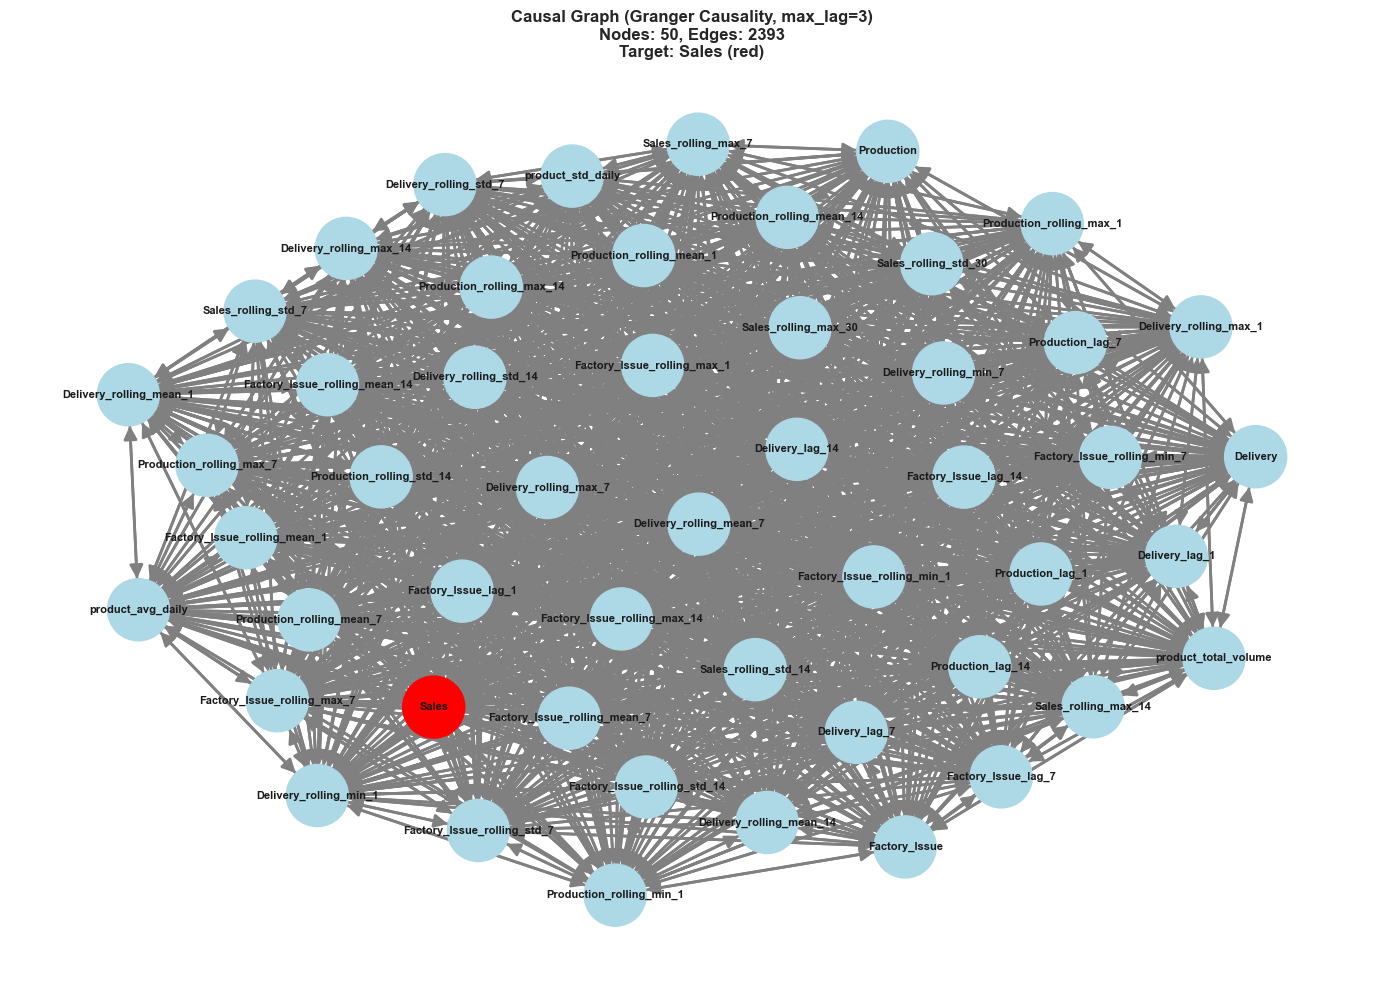

In [107]:
visualize_causal_graph(causal_graph, graph_info, target_col='Sales')


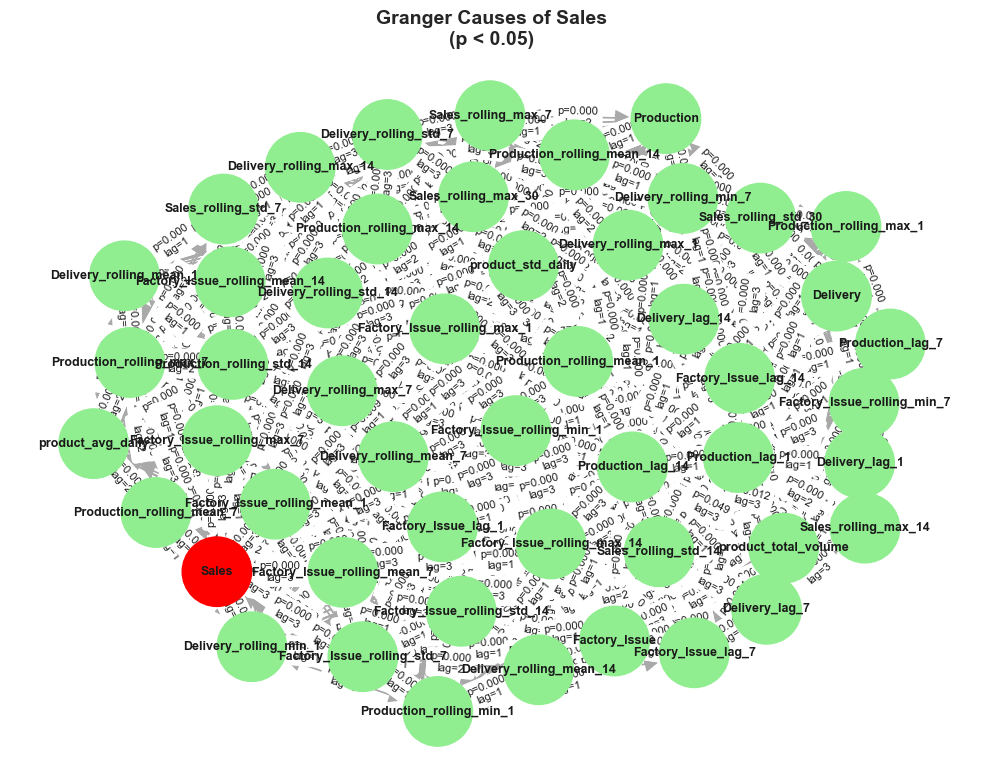

In [108]:
visualize_target_causes(causal_graph, graph_info, target_col='Sales')